## Stock Screener: Model Training and Evaluation

### Library Installation (if needed)

In [1]:
# Install libraries the first time
# ! conda install fastai::fastai conda-forge::yfinance pandas pathlib numpy

### Importing Required Libraries

In [2]:
from fastai.tabular.all import *
from fastai.metrics import rmse, mae
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import pathlib

### Variables

In [16]:
# Model settings
modelName = 'stockScreenerV1.8'
trainingData = 'stockData.csv'
getNewData = True 
trainNewModel = True
predictionTarget = 'AMRQF'  # 'ALL' for all, 'amount%', 'None' for no prediction

# Training parameters
trainingSize = 1400  # Number of stocks to use for training
timeFrame = '10y'   # Options: '1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max'
yNames = ['Future Year Change']
contNames = [
    'Open', 'Close', 'Volume', 'Dividends', 'Stock Splits',
    'EV/EBIT', 'ROIC']
catNames = ['Industry']
batchSize = 256
epochs = 33

# Testing parameters
testSize = 500  # Number of stocks to test, 'ALL' for all non-training stocks

# Paths
basePath = Path.cwd().parent
dataFolder = basePath / 'TrainingData'
modelFolder = basePath.parent / 'TrainedModels' / 'stockScreener'
testFolder = basePath / 'TestData'

## Data Preparation

#### Functions

In [4]:
def calculateFutureYearChange(ticker_symbol, timeframe, buffer=1):
    try:
        ticker = yf.Ticker(ticker_symbol)
        end_date = datetime.now().date()
        
        # Calculate required date range
        if timeframe == 'max':
            hist = ticker.history(period='max')
        else:
            years = int(timeframe[:-1])
            start_date = end_date - pd.DateOffset(years=years + buffer)
            
            # First check if ticker has existed long enough
            try:
                hist = ticker.history(start=start_date, end=end_date)
            except Exception as e:
                print(f"Data unavailable for {ticker_symbol} ({timeframe}): {e}")
                return pd.DataFrame()

        if hist.empty:
            print(f"No data found for {ticker_symbol} ({timeframe})")
            return pd.DataFrame()

        # Calculate future changes only if we have enough data points
        if len(hist) < 300:  # Minimum ~1.5 years of trading days
            print(f"Insufficient data for {ticker_symbol} ({len(hist)} rows)")
            return pd.DataFrame()

        # Calculate future price change
        hist['Future Year Change'] = (hist['Close'].shift(-252) / hist['Close'] - 1)
        hist = hist.dropna(subset=['Future Year Change'])
        
        return hist[['Open', 'Close', 'Volume', 'Dividends', 'Stock Splits', 
            'Future Year Change']].reset_index()

    except Exception as e:
        print(f"Error processing {ticker_symbol}: {str(e)}")
        return pd.DataFrame()

In [5]:
def calculateApproxEBIT(tickerSymbol):
    try:
        info = yf.Ticker(tickerSymbol).info
        revenue = info.get('totalRevenue', None)
        operatingIncome = info.get('operatingIncome', None)
        ebit = operatingIncome if operatingIncome else (revenue * 0.15 if revenue else None)
        return ebit if ebit and ebit != 0 else None  # Avoid zero division
    except Exception as e:
        return None

In [6]:
def enrichDataWithMetrics(histData):
    """Adds EV/EBIT and ROIC to the historical data."""
    # Initialize columns with NaN if they don't exist
    if 'EV/EBIT' not in histData.columns:
        histData['EV/EBIT'] = np.nan
    if 'ROIC' not in histData.columns:
        histData['ROIC'] = np.nan
    
    for ticker in histData['Ticker'].unique():
        try:
            evInfo = yf.Ticker(ticker).info
            totalDebt, cash, sharesOutstanding = evInfo.get('totalDebt', 0), evInfo.get('totalCash', 0), evInfo.get('sharesOutstanding', None)
            ebit = calculateApproxEBIT(ticker)

            if sharesOutstanding and ebit and ebit != 0:
                histData.loc[histData['Ticker'] == ticker, 'EV/EBIT'] = (
                    (histData['Close'] * sharesOutstanding + totalDebt - cash) / ebit
                )

                taxRate = 0.21
                nopat = ebit * (1 - taxRate)
                investedCapital = totalDebt + (histData['Close'] * sharesOutstanding) - cash
                histData.loc[histData['Ticker'] == ticker, 'ROIC'] = nopat / investedCapital
        except Exception as e:
            pass
    return histData

In [7]:
def getTickerDataFrom1YrAgo(ticker_symbol):
    try:
        # Fetch ticker data
        ticker = yf.Ticker(ticker_symbol)

        # Define the date range: one year ago to today
        today = datetime.today()
        one_year_ago = today - timedelta(days=365)

        # Fetch historical data for one year ago
        hist = ticker.history(start=(one_year_ago - timedelta(days=30)).strftime('%Y-%m-%d'), 
                              end=(one_year_ago + timedelta(days=0)).strftime('%Y-%m-%d'))
        if hist.empty:
            raise ValueError(f"No historical data available for {ticker_symbol} around {one_year_ago.strftime('%Y-%m-%d')}.")

        # Extract the closest data point to one year ago
        row = hist.iloc[0]  # Get the first available entry within the date range

        # Price today
        price_today = ticker.history(period='1d')['Close'].iloc[-1]

        # Calculate future price change (from one year ago to today)
        price_change_future = ((price_today - row['Close']) / row['Close']) if row['Close'] else None

        # Collect additional data
        evInfo = yf.Ticker(ticker_symbol).info
        total_debt, cash, shares_outstanding = evInfo.get('totalDebt', 0), evInfo.get('totalCash', 0), evInfo.get('sharesOutstanding', None)
        ebit = calculateApproxEBIT(ticker_symbol)
        ev = (row['Close'] * shares_outstanding) + total_debt - cash if shares_outstanding else None
        ev_ebit = ev / ebit if ebit else None
        market_cap = row['Close'] * shares_outstanding if shares_outstanding else None
        tax_rate = 0.21
        nopat = ebit * (1 - tax_rate) if ebit else None
        invested_capital = total_debt + market_cap - cash if market_cap and total_debt and cash else None
        roic = nopat / invested_capital if nopat and invested_capital else None
        industry = yf.Ticker(ticker_symbol).info.get('industry', 'Unknown')

        # Return as a DataFrame
        return pd.DataFrame([{
            'Ticker': ticker_symbol,
            'Date': row.name,
            'Open': row['Open'],
            'High': row['High'],
            'Low': row['Low'],
            'Close': row['Close'],
            'Volume': row['Volume'],
            'Dividends': row.get('Dividends', 0.0),
            'Stock Splits': row.get('Stock Splits', 0.0),
            'Future Year Change': price_change_future,
            'Industry': industry,
            'EV/EBIT': ev_ebit,
            'ROIC': roic
        }])

    except Exception as e:
        print(f"Error fetching data for {ticker_symbol}: {e}")
        return pd.DataFrame()

In [8]:
def getTickerData(ticker_symbol):
    try:
        ticker = yf.Ticker(ticker_symbol)
        hist = ticker.history(period='1d')
        evInfo = ticker.info
        total_debt, cash, shares_outstanding = evInfo.get('totalDebt', 0), evInfo.get('totalCash', 0), evInfo.get('sharesOutstanding', None)
        ebit = calculateApproxEBIT(ticker_symbol)
        ev = (hist['Close'].iloc[-1] * shares_outstanding) + total_debt - cash
        ev_ebit = ev / ebit if ebit else None
        market_cap = hist['Close'].iloc[-1] * shares_outstanding
        tax_rate = 0.21
        nopat = ebit * (1 - tax_rate) if ebit else None
        invested_capital = total_debt + market_cap - cash
        roic = nopat / invested_capital if nopat and invested_capital else None
        industry = yf.Ticker(ticker_symbol).info.get('industry', 'Unknown')
        
        # Add the 'Date' column
        date = datetime.now().strftime('%Y-%m-%d')

        return pd.DataFrame([{
            'Date': date,
            'Open': hist['Open'].iloc[-1],
            'High': hist['High'].iloc[-1],
            'Low': hist['Low'].iloc[-1],
            'Close': hist['Close'].iloc[-1],
            'Volume': hist['Volume'].iloc[-1],
            'Dividends': hist.get('Dividends', pd.Series([0.0])).iloc[-1],
            'Stock Splits': hist.get('Stock Splits', pd.Series([0.0])).iloc[-1],
            'EV/EBIT': ev_ebit,
            'Market Cap': market_cap,
            'ROIC': roic,
            'Industry': industry
        }])
    except Exception:
        return pd.DataFrame()

#### Download and Process Historical Data

In [9]:
tickers = pd.read_csv(testFolder / 'tickers.csv')['Ticker']
trainingTickers = np.random.choice(tickers, size=trainingSize, replace=False)

if getNewData:
    histData = pd.DataFrame()
    valid_tickers = []
    
    for ticker in trainingTickers:
        print(f"Processing {ticker}...")
        data = calculateFutureYearChange(ticker, timeFrame)
        if not data.empty:
            data['Ticker'] = ticker
            data['Industry'] = yf.Ticker(ticker).info.get('industry', 'Unknown')
            data['Date'] = pd.to_datetime(data['Date']).dt.tz_localize(None)
            
            # Enrich individual ticker data first
            ticker_data = enrichDataWithMetrics(data)
            histData = pd.concat([histData, ticker_data])
            
            # Check if metrics were added
            if 'ROIC' not in ticker_data.columns:
                print(f"WARNING: Failed to add metrics for {ticker}")
            
            valid_tickers.append(ticker)
        else:
            print(f"Skipped {ticker} - insufficient data")

    print(f"\nColumns in final dataset: {histData.columns.tolist()}")
    
    if not histData.empty:
        histData = enrichDataWithMetrics(histData)
        histData.to_csv(dataFolder / trainingData, index=True)
        # Verify no future targets leaked to past dates
        latest_date = pd.to_datetime(histData['Date']).max()
        if 'Future Year Change' in histData.columns:
            target_dates = histData[histData['Future Year Change'].notnull()]['Date']
            if any(pd.to_datetime(target_dates) > latest_date):
                raise ValueError("CRITICAL: Analyst targets contain future dates!")
        print(f"Saved training data with {len(histData)} rows")
    else:
        print("Warning: No data collected - check your tickers list")

Processing DLR-E...


$DLR-E: possibly delisted; no timezone found
$INPH: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for DLR-E (10y)
Skipped DLR-E - insufficient data
Processing INPH...
No data found for INPH (10y)
Skipped INPH - insufficient data
Processing SAFT...


$HUB.B: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing HUB.B...
No data found for HUB.B (10y)
Skipped HUB.B - insufficient data
Processing AGC...


$AGC: possibly delisted; no timezone found


No data found for AGC (10y)
Skipped AGC - insufficient data
Processing HZO...
Processing TFX...
Processing TSM...


$DGAS: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing DGAS...
No data found for DGAS (10y)
Skipped DGAS - insufficient data
Processing DGX...
Processing SHEN...
Processing GSE...
Processing HEP...


$HEP: possibly delisted; no timezone found


No data found for HEP (10y)
Skipped HEP - insufficient data
Processing JGT...


$JGT: possibly delisted; no timezone found
$RTK: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for JGT (10y)
Skipped JGT - insufficient data
Processing RTK...
No data found for RTK (10y)
Skipped RTK - insufficient data
Processing CLSN...


$CLSN: possibly delisted; no timezone found


No data found for CLSN (10y)
Skipped CLSN - insufficient data
Processing SYMC...


$SYMC: possibly delisted; no timezone found


No data found for SYMC (10y)
Skipped SYMC - insufficient data
Processing SMSI...


$HCLP: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing HCLP...
No data found for HCLP (10y)
Skipped HCLP - insufficient data
Processing BVSN...


$BVSN: possibly delisted; no timezone found


No data found for BVSN (10y)
Skipped BVSN - insufficient data
Processing STRN...


$STRN: possibly delisted; no timezone found
$FBN: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for STRN (10y)
Skipped STRN - insufficient data
Processing FBN...
No data found for FBN (10y)
Skipped FBN - insufficient data
Processing NBG-A...


$NBG-A: possibly delisted; no timezone found


No data found for NBG-A (10y)
Skipped NBG-A - insufficient data
Processing CYS-A...


$CYS-A: possibly delisted; no timezone found


No data found for CYS-A (10y)
Skipped CYS-A - insufficient data
Processing ARWR...


$JOSB: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing JOSB...
No data found for JOSB (10y)
Skipped JOSB - insufficient data
Processing GGB...


$BSFT: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing BSFT...
No data found for BSFT (10y)
Skipped BSFT - insufficient data
Processing BGCP...


$BGCP: possibly delisted; no timezone found


No data found for BGCP (10y)
Skipped BGCP - insufficient data
Processing RLI...
Processing SIVB...


$SIVB: possibly delisted; no timezone found


No data found for SIVB (10y)
Skipped SIVB - insufficient data
Processing NAV...


$NAV: possibly delisted; no timezone found


No data found for NAV (10y)
Skipped NAV - insufficient data
Processing LPLA...
Processing HFBC...


$HFBC: possibly delisted; no timezone found


No data found for HFBC (10y)
Skipped HFBC - insufficient data
Processing CAF...
Processing QCRH...


$CVC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$RDEN: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing CVC...
No data found for CVC (10y)
Skipped CVC - insufficient data
Processing RDEN...
No data found for RDEN (10y)
Skipped RDEN - insufficient data
Processing EZCH...


$EZCH: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for EZCH (10y)
Skipped EZCH - insufficient data
Processing ROYT...


$ROYT: possibly delisted; no timezone found


No data found for ROYT (10y)
Skipped ROYT - insufficient data
Processing FULLL...


$FULLL: possibly delisted; no timezone found


No data found for FULLL (10y)
Skipped FULLL - insufficient data
Processing CSTM...
Processing BTT...


$RIOM: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing RIOM...
No data found for RIOM (10y)
Skipped RIOM - insufficient data
Processing STB...


$STB: possibly delisted; no timezone found


No data found for STB (10y)
Skipped STB - insufficient data
Processing ATNI...


$ACAS: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing ACAS...
No data found for ACAS (10y)
Skipped ACAS - insufficient data
Processing CTZ-A...


$CTZ-A: possibly delisted; no timezone found


No data found for CTZ-A (10y)
Skipped CTZ-A - insufficient data
Processing KMF...


$KMF: possibly delisted; no timezone found


No data found for KMF (10y)
Skipped KMF - insufficient data
Processing AEM...
Processing HI...
Processing DIN...
Processing ROICW...


$ROICW: possibly delisted; no timezone found


No data found for ROICW (10y)
Skipped ROICW - insufficient data
Processing AAPL...
Processing SMLP...


$SMLP: possibly delisted; no timezone found


No data found for SMLP (10y)
Skipped SMLP - insufficient data
Processing GOLD...
Processing TC-T...


$TC-T: possibly delisted; no timezone found
$RAX: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$ZX: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for TC-T (10y)
Skipped TC-T - insufficient data
Processing RAX...
No data found for RAX (10y)
Skipped RAX - insufficient data
Processing ZX...
No data found for ZX (10y)
Skipped ZX - insufficient data
Processing UBA...


$UBA: possibly delisted; no timezone found
$BLOX: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for UBA (10y)
Skipped UBA - insufficient data
Processing BLOX...
No data found for BLOX (10y)
Skipped BLOX - insufficient data
Processing PNM...


$PNM: possibly delisted; no timezone found


No data found for PNM (10y)
Skipped PNM - insufficient data
Processing PAY...
Processing CMS-B...


$CMS-B: possibly delisted; no timezone found


No data found for CMS-B (10y)
Skipped CMS-B - insufficient data
Processing TK...
Processing FII...


$FII: possibly delisted; no timezone found


No data found for FII (10y)
Skipped FII - insufficient data
Processing GGT...
Processing NMI...


$GY: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing GY...
No data found for GY (10y)
Skipped GY - insufficient data
Processing CY...


$CY: possibly delisted; no timezone found
$FULL: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for CY (10y)
Skipped CY - insufficient data
Processing FULL...
No data found for FULL (10y)
Skipped FULL - insufficient data
Processing EXEL...
Processing SAN-A...


$SAN-A: possibly delisted; no timezone found


No data found for SAN-A (10y)
Skipped SAN-A - insufficient data
Processing TUES...


$TUES: possibly delisted; no timezone found


No data found for TUES (10y)
Skipped TUES - insufficient data
Processing KINS...
Processing LANC...
Processing CRS...
Processing PL-B...


$PL-B: possibly delisted; no timezone found


No data found for PL-B (10y)
Skipped PL-B - insufficient data
Processing DDR-K...


$DDR-K: possibly delisted; no timezone found


No data found for DDR-K (10y)
Skipped DDR-K - insufficient data
Processing EMD...
Processing ONB...
Processing PERI...
Processing CHFC...


$CHFC: possibly delisted; no timezone found


No data found for CHFC (10y)
Skipped CHFC - insufficient data
Processing CLUB...


$CLUB: possibly delisted; no timezone found


No data found for CLUB (10y)
Skipped CLUB - insufficient data
Processing CPE-A...


$CPE-A: possibly delisted; no timezone found


No data found for CPE-A (10y)
Skipped CPE-A - insufficient data
Processing RZA...


$RZA: possibly delisted; no timezone found
$IMMY: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for RZA (10y)
Skipped RZA - insufficient data
Processing IMMY...
No data found for IMMY (10y)
Skipped IMMY - insufficient data
Processing NMY-H...


$NMY-H: possibly delisted; no timezone found


No data found for NMY-H (10y)
Skipped NMY-H - insufficient data
Processing ACST...


$ACST: possibly delisted; no timezone found


No data found for ACST (10y)
Skipped ACST - insufficient data
Processing IFSM...


$IFSM: possibly delisted; no timezone found


No data found for IFSM (10y)
Skipped IFSM - insufficient data
Processing BORN...


$BORN: possibly delisted; no timezone found


No data found for BORN (10y)
Skipped BORN - insufficient data
Processing GNMA...


$CNDO: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing CNDO...
No data found for CNDO (10y)
Skipped CNDO - insufficient data
Processing PCRX...
Processing MAG...
Processing CU...
Insufficient data for CU (282 rows)
Skipped CU - insufficient data
Processing LKFN...
Processing FSRV...


$FSRV: possibly delisted; no timezone found


No data found for FSRV (10y)
Skipped FSRV - insufficient data
Processing GLRE...
Processing CYE...
Processing ST...


$PLMT: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing PLMT...
No data found for PLMT (10y)
Skipped PLMT - insufficient data
Processing HPP-B...


$HPP-B: possibly delisted; no timezone found


No data found for HPP-B (10y)
Skipped HPP-B - insufficient data
Processing PM...
Processing FISI...
Processing TITN...
Processing SM...
Processing BZT...


$BZT: possibly delisted; no timezone found


No data found for BZT (10y)
Skipped BZT - insufficient data
Processing INVN...
Insufficient data for INVN (1 rows)
Skipped INVN - insufficient data
Processing NETC...


$NETC: possibly delisted; no timezone found


No data found for NETC (10y)
Skipped NETC - insufficient data
Processing AGO-F...


$AGO-F: possibly delisted; no timezone found


No data found for AGO-F (10y)
Skipped AGO-F - insufficient data
Processing KCLI...
Processing SRCL...
Processing DHX...
Processing CBMXW...


$CBMXW: possibly delisted; no timezone found
$ZINC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for CBMXW (10y)
Skipped CBMXW - insufficient data
Processing ZINC...
No data found for ZINC (10y)
Skipped ZINC - insufficient data
Processing NMY...


$NMY: possibly delisted; no timezone found
$CKEC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$ARPI: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for NMY (10y)
Skipped NMY - insufficient data
Processing CKEC...
No data found for CKEC (10y)
Skipped CKEC - insufficient data
Processing ARPI...
No data found for ARPI (10y)
Skipped ARPI - insufficient data
Processing VRNM...


$VRNM: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for VRNM (10y)
Skipped VRNM - insufficient data
Processing LOCM...
Processing FRM...
Processing TST...


$TST: possibly delisted; no timezone found


No data found for TST (10y)
Skipped TST - insufficient data
Processing SOHU...
Processing SUPN...
Processing GG...


$GG: possibly delisted; no timezone found
$VVTV: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for GG (10y)
Skipped GG - insufficient data
Processing VVTV...
No data found for VVTV (10y)
Skipped VVTV - insufficient data
Processing IBOC...
Processing CCL...
Processing SKY...
Processing ELGX...


$ELGX: possibly delisted; no timezone found


No data found for ELGX (10y)
Skipped ELGX - insufficient data
Processing CLB...
Processing BRO...


$PVFC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$PMFG: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing PVFC...
No data found for PVFC (10y)
Skipped PVFC - insufficient data
Processing PMFG...
No data found for PMFG (10y)
Skipped PMFG - insufficient data
Processing OXBT...


$OXBT: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for OXBT (10y)
Skipped OXBT - insufficient data
Processing DYSL...
Processing AMBA...
Processing FAST...
Processing NUS...


$SGNT: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$UACL: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing SGNT...
No data found for SGNT (10y)
Skipped SGNT - insufficient data
Processing UACL...
No data found for UACL (10y)
Skipped UACL - insufficient data
Processing AMX...


$KNM: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing KNM...
No data found for KNM (10y)
Skipped KNM - insufficient data
Processing MANU...
Processing CFFN...
Processing HES...
Processing HBC...
Processing FBNK...


$FBNK: possibly delisted; no timezone found
$TWGP: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for FBNK (10y)
Skipped FBNK - insufficient data
Processing TWGP...
No data found for TWGP (10y)
Skipped TWGP - insufficient data
Processing KTH...
Processing NEE-C...


$NEE-C: possibly delisted; no timezone found


No data found for NEE-C (10y)
Skipped NEE-C - insufficient data
Processing SFI-D...


$SFI-D: possibly delisted; no timezone found


No data found for SFI-D (10y)
Skipped SFI-D - insufficient data
Processing DL...


$DL: possibly delisted; no timezone found


No data found for DL (10y)
Skipped DL - insufficient data
Processing BSP...


$GAGA: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing GAGA...
No data found for GAGA (10y)
Skipped GAGA - insufficient data
Processing BPK...
Processing GLBS...
Processing IRBT...


$SCL.P: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing SCL.P...
No data found for SCL.P (10y)
Skipped SCL.P - insufficient data
Processing RPAI...


$RPAI: possibly delisted; no timezone found
$NQI: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for RPAI (10y)
Skipped RPAI - insufficient data
Processing NQI...
No data found for NQI (10y)
Skipped NQI - insufficient data
Processing NLY...
Processing SMA...
Processing PZZA...
Processing ROP...
Processing DLTR...
Processing LXU...
Processing WIRE...


$WIRE: possibly delisted; no timezone found


No data found for WIRE (10y)
Skipped WIRE - insufficient data
Processing XLNX...


$XLNX: possibly delisted; no timezone found


No data found for XLNX (10y)
Skipped XLNX - insufficient data
Processing LSCC...
Processing FITB...
Processing PERF...


$HSNI: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing HSNI...
No data found for HSNI (10y)
Skipped HSNI - insufficient data
Processing STRM...
Processing ING...
Processing KOOL...
Insufficient data for KOOL (205 rows)
Skipped KOOL - insufficient data
Processing ITT...


$MHR: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing MHR...
No data found for MHR (10y)
Skipped MHR - insufficient data
Processing GTLS...
Processing BRS...


$BRS: possibly delisted; no timezone found


No data found for BRS (10y)
Skipped BRS - insufficient data
Processing CLP...
Processing XL...


$XL: possibly delisted; no timezone found


No data found for XL (10y)
Skipped XL - insufficient data
Processing OTTR...


$CACB: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing CACB...
No data found for CACB (10y)
Skipped CACB - insufficient data
Processing FTNT...
Processing RHP...
Processing LLY...
Processing GSIT...


$ATK: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing ATK...
No data found for ATK (10y)
Skipped ATK - insufficient data
Processing CHNR...
Processing INTLL...


$INTLL: possibly delisted; no timezone found


No data found for INTLL (10y)
Skipped INTLL - insufficient data
Processing BLIN...
Processing GGP-A...


$GGP-A: possibly delisted; no timezone found


No data found for GGP-A (10y)
Skipped GGP-A - insufficient data
Processing DARA...
Processing CBT...
Processing JVA...


$ISSI: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$PPO: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing ISSI...
No data found for ISSI (10y)
Skipped ISSI - insufficient data
Processing PPO...
No data found for PPO (10y)
Skipped PPO - insufficient data
Processing ROST...
Processing ORLY...
Processing NATL...
Processing SFB...
Insufficient data for SFB (1 rows)
Skipped SFB - insufficient data
Processing ATTU...


$ATTU: possibly delisted; no timezone found
$NBCB: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$WPPGY: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for ATTU (10y)
Skipped ATTU - insufficient data
Processing NBCB...
No data found for NBCB (10y)
Skipped NBCB - insufficient data
Processing WPPGY...
No data found for WPPGY (10y)
Skipped WPPGY - insufficient data
Processing PSTR...


$FSL: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Insufficient data for PSTR (185 rows)
Skipped PSTR - insufficient data
Processing FSL...
No data found for FSL (10y)
Skipped FSL - insufficient data
Processing UVSP...
Processing PFBC...
Processing DNKN...


$DNKN: possibly delisted; no timezone found


No data found for DNKN (10y)
Skipped DNKN - insufficient data
Processing INOD...
Processing ITRI...
Processing SCX...


$SCX: possibly delisted; no timezone found


No data found for SCX (10y)
Skipped SCX - insufficient data
Processing HTH...
Processing PMF...
Processing SHO-D...


$SHO-D: possibly delisted; no timezone found


No data found for SHO-D (10y)
Skipped SHO-D - insufficient data
Processing KBH...
Processing RTIX...


$RTIX: possibly delisted; no timezone found


No data found for RTIX (10y)
Skipped RTIX - insufficient data
Processing ORI...
Processing RT...
Processing RBS-P...


$RBS-P: possibly delisted; no timezone found
$ENL: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for RBS-P (10y)
Skipped RBS-P - insufficient data
Processing ENL...
No data found for ENL (10y)
Skipped ENL - insufficient data
Processing MPC...
Processing SSTK...
Processing CUI...


$CUI: possibly delisted; no timezone found


No data found for CUI (10y)
Skipped CUI - insufficient data
Processing POOL...
Processing PRMW...


$PRMW: possibly delisted; no timezone found


No data found for PRMW (10y)
Skipped PRMW - insufficient data
Processing EPR-E...


$EPR-E: possibly delisted; no timezone found


No data found for EPR-E (10y)
Skipped EPR-E - insufficient data
Processing PFE...
Processing ARY...


$ARY: possibly delisted; no timezone found


No data found for ARY (10y)
Skipped ARY - insufficient data
Processing FVE...


$FVE: possibly delisted; no timezone found
$ESSX: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for FVE (10y)
Skipped FVE - insufficient data
Processing ESSX...
No data found for ESSX (10y)
Skipped ESSX - insufficient data
Processing GLBZ...
Processing ENT...


$ENT: possibly delisted; no timezone found


No data found for ENT (10y)
Skipped ENT - insufficient data
Processing VTNC...
Insufficient data for VTNC (44 rows)
Skipped VTNC - insufficient data
Processing BHY...


$BHY: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for BHY (10y)
Skipped BHY - insufficient data
Processing KELYA...
Processing PRO...
Processing FMC...
Processing ICLR...
Processing LRN...
Processing PPC...
Processing TNXP...
Processing MFA...
Processing SRI...


$VSCI: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing VSCI...
No data found for VSCI (10y)
Skipped VSCI - insufficient data
Processing HSON...


$ANAD: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing ANAD...
No data found for ANAD (10y)
Skipped ANAD - insufficient data
Processing ASC...
Processing FDUS...


$RKUS: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$DNY: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing RKUS...
No data found for RKUS (10y)
Skipped RKUS - insufficient data
Processing DNY...
No data found for DNY (10y)
Skipped DNY - insufficient data
Processing MSON...


$MSON: possibly delisted; no timezone found
$EPL: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for MSON (10y)
Skipped MSON - insufficient data
Processing EPL...
No data found for EPL (10y)
Skipped EPL - insufficient data
Processing AMCN...


$AMCN: possibly delisted; no timezone found
$BYI: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for AMCN (10y)
Skipped AMCN - insufficient data
Processing BYI...
No data found for BYI (10y)
Skipped BYI - insufficient data
Processing DUC...


$DUC: possibly delisted; no timezone found


No data found for DUC (10y)
Skipped DUC - insufficient data
Processing EBR...


$HME: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$ASBI: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing HME...
No data found for HME (10y)
Skipped HME - insufficient data
Processing ASBI...
No data found for ASBI (10y)
Skipped ASBI - insufficient data
Processing HBA-H...


$HBA-H: possibly delisted; no timezone found


No data found for HBA-H (10y)
Skipped HBA-H - insufficient data
Processing ACRX...


$ACRX: possibly delisted; no timezone found


No data found for ACRX (10y)
Skipped ACRX - insufficient data
Processing JNPR...
Processing TESS...


$TESS: possibly delisted; no timezone found


No data found for TESS (10y)
Skipped TESS - insufficient data
Processing BOCH...


$BOCH: possibly delisted; no timezone found


No data found for BOCH (10y)
Skipped BOCH - insufficient data
Processing MFSF...


$MFSF: possibly delisted; no timezone found


No data found for MFSF (10y)
Skipped MFSF - insufficient data
Processing MRCC...
Processing TDF...
Processing ABC...


$ABC: possibly delisted; no timezone found
$LRY: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$TWTC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for ABC (10y)
Skipped ABC - insufficient data
Processing LRY...
No data found for LRY (10y)
Skipped LRY - insufficient data
Processing TWTC...
No data found for TWTC (10y)
Skipped TWTC - insufficient data
Processing BSX...
Processing PSCT...
Processing MSFT...
Processing MTSL...


$MTSL: possibly delisted; no timezone found


No data found for MTSL (10y)
Skipped MTSL - insufficient data
Processing FTI...
Processing BANR...


$ANLY: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing ANLY...
No data found for ANLY (10y)
Skipped ANLY - insufficient data
Processing MGIC...
Processing CIM...


$NWY: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing NWY...
No data found for NWY (10y)
Skipped NWY - insufficient data
Processing AIN...
Processing PRI...
Processing ACFC...
Processing ADP...
Processing UTI...
Processing CB...
Processing CRD.B...


$CRD.B: possibly delisted; no timezone found


No data found for CRD.B (10y)
Skipped CRD.B - insufficient data
Processing NTL...


$GLPW: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing GLPW...
No data found for GLPW (10y)
Skipped GLPW - insufficient data
Processing CBM...


$CBM: possibly delisted; no timezone found


No data found for CBM (10y)
Skipped CBM - insufficient data
Processing VSAT...
Processing DENN...
Processing CMO-E...


$CMO-E: possibly delisted; no timezone found


No data found for CMO-E (10y)
Skipped CMO-E - insufficient data
Processing CNX...
Processing BKI...


$BKI: possibly delisted; no timezone found


No data found for BKI (10y)
Skipped BKI - insufficient data
Processing JIVE...
Processing NUO-C...


$NUO-C: possibly delisted; no timezone found
$CBIN: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for NUO-C (10y)
Skipped NUO-C - insufficient data
Processing CBIN...
No data found for CBIN (10y)
Skipped CBIN - insufficient data
Processing EVOL...
Processing VCRA...


$VCRA: possibly delisted; no timezone found


No data found for VCRA (10y)
Skipped VCRA - insufficient data
Processing FIBK...
Processing HPOL...
Insufficient data for HPOL (6 rows)
Skipped HPOL - insufficient data
Processing CUZ...
Processing VRTU...


$VRTU: possibly delisted; no timezone found


No data found for VRTU (10y)
Skipped VRTU - insufficient data
Processing FRED...


$FRED: possibly delisted; no timezone found


No data found for FRED (10y)
Skipped FRED - insufficient data
Processing JADE...
Insufficient data for JADE (172 rows)
Skipped JADE - insufficient data
Processing GTIM...
Processing IVC...


$IVC: possibly delisted; no timezone found


No data found for IVC (10y)
Skipped IVC - insufficient data
Processing DAL...
Processing PSCF...
Processing SNI...
Processing PSA...
Processing GPRE...


$GJM: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing GJM...
No data found for GJM (10y)
Skipped GJM - insufficient data
Processing C-S...


$C-S: possibly delisted; no timezone found


No data found for C-S (10y)
Skipped C-S - insufficient data
Processing UFCS...
Processing RTN...


$RTN: possibly delisted; no timezone found


No data found for RTN (10y)
Skipped RTN - insufficient data
Processing SOL...


$KYO: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing KYO...
No data found for KYO (10y)
Skipped KYO - insufficient data
Processing TPX...
Processing EGBN...
Processing MPX...
Processing BNA...
Processing LNC.W...


$LNC.W: possibly delisted; no timezone found
$YOKU: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for LNC.W (10y)
Skipped LNC.W - insufficient data
Processing YOKU...
No data found for YOKU (10y)
Skipped YOKU - insufficient data
Processing NAII...


$MSK: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing MSK...
No data found for MSK (10y)
Skipped MSK - insufficient data
Processing BBRY...


$BBRY: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for BBRY (10y)
Skipped BBRY - insufficient data
Processing PTLA...


$PTLA: possibly delisted; no timezone found


No data found for PTLA (10y)
Skipped PTLA - insufficient data
Processing ENH-B...


$ENH-B: possibly delisted; no timezone found


No data found for ENH-B (10y)
Skipped ENH-B - insufficient data
Processing HITK...
Insufficient data for HITK (58 rows)
Skipped HITK - insufficient data
Processing ACOR...


$ACOR: possibly delisted; no timezone found
$LBF: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for ACOR (10y)
Skipped ACOR - insufficient data
Processing LBF...
No data found for LBF (10y)
Skipped LBF - insufficient data
Processing NVDA...


$PSTB: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing PSTB...
No data found for PSTB (10y)
Skipped PSTB - insufficient data
Processing LTC...
Processing BDC...
Processing VIVO...


$VIVO: possibly delisted; no timezone found


No data found for VIVO (10y)
Skipped VIVO - insufficient data
Processing CHCI...
Processing BLDR...
Processing PVG...


$PVG: possibly delisted; no timezone found


No data found for PVG (10y)
Skipped PVG - insufficient data
Processing RRC...
Processing CRD.A...


$CRD.A: possibly delisted; no timezone found


No data found for CRD.A (10y)
Skipped CRD.A - insufficient data
Processing GGE...


$GGE: possibly delisted; no timezone found


No data found for GGE (10y)
Skipped GGE - insufficient data
Processing MMM...
Processing FCN...
Processing CISAW...


$CISAW: possibly delisted; no timezone found


No data found for CISAW (10y)
Skipped CISAW - insufficient data
Processing BGB...
Processing HJV...


$HJV: possibly delisted; no timezone found


No data found for HJV (10y)
Skipped HJV - insufficient data
Processing FIF...


$FIF: possibly delisted; no timezone found


No data found for FIF (10y)
Skipped FIF - insufficient data
Processing KALU...
Processing CXO...


$CXO: possibly delisted; no timezone found


No data found for CXO (10y)
Skipped CXO - insufficient data
Processing NUCL...
Insufficient data for NUCL (182 rows)
Skipped NUCL - insufficient data
Processing FFKT...
Processing TRNS...


$NTI: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing NTI...
No data found for NTI (10y)
Skipped NTI - insufficient data
Processing RESI...
Processing ONTX...


$ONTX: possibly delisted; no timezone found


No data found for ONTX (10y)
Skipped ONTX - insufficient data
Processing FFNW...
Processing COL...
Processing FLEX...


$OPTR: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$BCS.P: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing OPTR...
No data found for OPTR (10y)
Skipped OPTR - insufficient data
Processing BCS.P...
No data found for BCS.P (10y)
Skipped BCS.P - insufficient data
Processing AOD...
Processing PGEM...
Processing FSFG...
Processing CMRE...
Processing RY...
Processing GUT...
Processing DVM...


$DVM: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for DVM (10y)
Skipped DVM - insufficient data
Processing RKT...
Processing EMMS...
Processing PJA...
Insufficient data for PJA (12 rows)
Skipped PJA - insufficient data
Processing AWAY...
Processing WMGIZ...


$WMGIZ: possibly delisted; no timezone found


No data found for WMGIZ (10y)
Skipped WMGIZ - insufficient data
Processing NP...


$NP: possibly delisted; no timezone found


No data found for NP (10y)
Skipped NP - insufficient data
Processing PHA...
Insufficient data for PHA (194 rows)
Skipped PHA - insufficient data
Processing SPTN...
Processing ED...


$OSHC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing OSHC...
No data found for OSHC (10y)
Skipped OSHC - insufficient data
Processing BID...


$BID: possibly delisted; no timezone found


No data found for BID (10y)
Skipped BID - insufficient data
Processing CECO...
Processing VAR...


$VAR: possibly delisted; no timezone found


No data found for VAR (10y)
Skipped VAR - insufficient data
Processing AIQ...


$ONXX: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing ONXX...
No data found for ONXX (10y)
Skipped ONXX - insufficient data
Processing DRCO...


$DRCO: possibly delisted; no timezone found
$PCLN: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for DRCO (10y)
Skipped DRCO - insufficient data
Processing PCLN...
No data found for PCLN (10y)
Skipped PCLN - insufficient data
Processing AOS...
Processing AMH...
Processing SHW...
Processing ROG...
Processing RITT...
Processing TYY-C...


$TYY-C: possibly delisted; no timezone found


No data found for TYY-C (10y)
Skipped TYY-C - insufficient data
Processing CRL...
Processing EVR...
Processing AHT-PD...
Processing UAN...
Processing AVNW...
Processing COO...
Processing ESLT...
Processing TIF...


$TIF: possibly delisted; no timezone found


No data found for TIF (10y)
Skipped TIF - insufficient data
Processing BMC...
Processing NGZ...
Processing PNTR...


$PNTR: possibly delisted; no timezone found


No data found for PNTR (10y)
Skipped PNTR - insufficient data
Processing CACH...
Processing RBS-F...


$RBS-F: possibly delisted; no timezone found


No data found for RBS-F (10y)
Skipped RBS-F - insufficient data
Processing LNT...
Processing NQP...
Processing CXH...
Processing IRET...
Insufficient data for IRET (223 rows)
Skipped IRET - insufficient data
Processing BGSCU...


$BGSCU: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for BGSCU (10y)
Skipped BGSCU - insufficient data
Processing RHI...


$LLTC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing LLTC...
No data found for LLTC (10y)
Skipped LLTC - insufficient data
Processing SBCF...
Processing CFR...
Processing TAYCO...


$TAYCO: possibly delisted; no timezone found


No data found for TAYCO (10y)
Skipped TAYCO - insufficient data
Processing HMNF...


$HMNF: possibly delisted; no timezone found
$WILN: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for HMNF (10y)
Skipped HMNF - insufficient data
Processing WILN...
No data found for WILN (10y)
Skipped WILN - insufficient data
Processing NL...
Processing CDW...
Processing ELLI...


$ELLI: possibly delisted; no timezone found


No data found for ELLI (10y)
Skipped ELLI - insufficient data
Processing EVHC...
Processing MEIL...


$ESC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing ESC...
No data found for ESC (10y)
Skipped ESC - insufficient data
Processing HIO...
Processing CLNE...
Processing CASY...
Processing ARKR...
Processing CLI...


$CLI: possibly delisted; no timezone found


No data found for CLI (10y)
Skipped CLI - insufficient data
Processing TWN...
Processing AWRE...
Processing HRC...


$HRC: possibly delisted; no timezone found


No data found for HRC (10y)
Skipped HRC - insufficient data
Processing CRT...
Processing JKHY...
Processing CARB...


$CARB: possibly delisted; no timezone found


No data found for CARB (10y)
Skipped CARB - insufficient data
Processing BFR...


$BFR: possibly delisted; no timezone found


No data found for BFR (10y)
Skipped BFR - insufficient data
Processing OFED...


$VOCS: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing VOCS...
No data found for VOCS (10y)
Skipped VOCS - insufficient data
Processing ACET...
Processing RDNT...
Processing CVI...
Processing KTCC...


$CSUN: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing CSUN...
No data found for CSUN (10y)
Skipped CSUN - insufficient data
Processing STAA...
Processing MIT-A...


$MIT-A: possibly delisted; no timezone found


No data found for MIT-A (10y)
Skipped MIT-A - insufficient data
Processing CHH...
Processing PNC-Q...


$PNC-Q: possibly delisted; no timezone found


No data found for PNC-Q (10y)
Skipped PNC-Q - insufficient data
Processing IRL...


$IRL: possibly delisted; no timezone found


No data found for IRL (10y)
Skipped IRL - insufficient data
Processing RCL...
Processing MSJ...


$MSJ: possibly delisted; no timezone found


No data found for MSJ (10y)
Skipped MSJ - insufficient data
Processing KRNY...
Processing CFBK...
Processing RVLT...


$RVLT: possibly delisted; no timezone found
$REXI: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for RVLT (10y)
Skipped RVLT - insufficient data
Processing REXI...
No data found for REXI (10y)
Skipped REXI - insufficient data
Processing ALLT...
Processing SPG...
Processing THC...
Processing SLB...
Processing BTU...
Processing NWSA...
Processing USAC...
Processing ESL...


$ESL: possibly delisted; no timezone found


No data found for ESL (10y)
Skipped ESL - insufficient data
Processing HTCO...
Processing CYOU...


$CYOU: possibly delisted; no timezone found


No data found for CYOU (10y)
Skipped CYOU - insufficient data
Processing JLA...


$JLA: possibly delisted; no timezone found


No data found for JLA (10y)
Skipped JLA - insufficient data
Processing ANDAU...


$ANDAU: possibly delisted; no timezone found


No data found for ANDAU (10y)
Skipped ANDAU - insufficient data
Processing BH...


$MY: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing MY...
No data found for MY (10y)
Skipped MY - insufficient data
Processing KIM-J...


$KIM-J: possibly delisted; no timezone found
$VYFC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for KIM-J (10y)
Skipped KIM-J - insufficient data
Processing VYFC...
No data found for VYFC (10y)
Skipped VYFC - insufficient data
Processing ITG...


$ITG: possibly delisted; no timezone found


No data found for ITG (10y)
Skipped ITG - insufficient data
Processing RDCM...
Processing NCA...
Processing WLFC...
Processing CIA...
Processing ARDC...


$BGSCW: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing BGSCW...
No data found for BGSCW (10y)
Skipped BGSCW - insufficient data
Processing ENTR...
Processing SYNC...


$SYNC: possibly delisted; no timezone found


No data found for SYNC (10y)
Skipped SYNC - insufficient data
Processing ATV...


$ATV: possibly delisted; no timezone found


No data found for ATV (10y)
Skipped ATV - insufficient data
Processing ALSK...


$ALSK: possibly delisted; no timezone found


No data found for ALSK (10y)
Skipped ALSK - insufficient data
Processing EMCI...


$EMCI: possibly delisted; no timezone found
$ERS: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for EMCI (10y)
Skipped EMCI - insufficient data
Processing ERS...
No data found for ERS (10y)
Skipped ERS - insufficient data
Processing RNWK...


$RNWK: possibly delisted; no timezone found
$JRCC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$ATNY: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for RNWK (10y)
Skipped RNWK - insufficient data
Processing JRCC...
No data found for JRCC (10y)
Skipped JRCC - insufficient data
Processing ATNY...
No data found for ATNY (10y)
Skipped ATNY - insufficient data
Processing HYLS...
Processing BNCL...


$BNCL: possibly delisted; no timezone found
$PYB: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for BNCL (10y)
Skipped BNCL - insufficient data
Processing PYB...
No data found for PYB (10y)
Skipped PYB - insufficient data
Processing SVU...
Processing HE...
Processing RXN...


$RXN: possibly delisted; no timezone found


No data found for RXN (10y)
Skipped RXN - insufficient data
Processing FRC-C...


$FRC-C: possibly delisted; no timezone found
$PATR: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for FRC-C (10y)
Skipped FRC-C - insufficient data
Processing PATR...
No data found for PATR (10y)
Skipped PATR - insufficient data
Processing DHI...
Processing GCBC...
Processing RDC...


$RDC: possibly delisted; no timezone found


No data found for RDC (10y)
Skipped RDC - insufficient data
Processing BML-I...


$BML-I: possibly delisted; no timezone found


No data found for BML-I (10y)
Skipped BML-I - insufficient data
Processing SGOC...


$SGOC: possibly delisted; no timezone found


No data found for SGOC (10y)
Skipped SGOC - insufficient data
Processing ALXN...


$ALXN: possibly delisted; no timezone found


No data found for ALXN (10y)
Skipped ALXN - insufficient data
Processing BLL...


$BLL: possibly delisted; no timezone found
$FEIC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for BLL (10y)
Skipped BLL - insufficient data
Processing FEIC...
No data found for FEIC (10y)
Skipped FEIC - insufficient data
Processing HPI...
Processing SMTX...


$SMTX: possibly delisted; no timezone found
$WAC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for SMTX (10y)
Skipped SMTX - insufficient data
Processing WAC...
No data found for WAC (10y)
Skipped WAC - insufficient data
Processing PGZ...
Processing ADTN...
Processing KEP...
Processing AMKR...
Processing SEAC...
Processing GCV...
Processing UFS...


$UFS: possibly delisted; no timezone found


No data found for UFS (10y)
Skipped UFS - insufficient data
Processing RAND...
Processing SNHY...


$SNHY: possibly delisted; no timezone found


No data found for SNHY (10y)
Skipped SNHY - insufficient data
Processing USG...
Processing HA...


$HA: possibly delisted; no timezone found


No data found for HA (10y)
Skipped HA - insufficient data
Processing JSM...
Processing ELJ...


$ELJ: possibly delisted; no timezone found


No data found for ELJ (10y)
Skipped ELJ - insufficient data
Processing YUM...
Processing BLK...
Processing FCHI...


$FCHI: possibly delisted; no timezone found


No data found for FCHI (10y)
Skipped FCHI - insufficient data
Processing SCI...
Processing FCCY...


$FCCY: possibly delisted; no timezone found


No data found for FCCY (10y)
Skipped FCCY - insufficient data
Processing GIGM...
Processing LHO-H...


$LHO-H: possibly delisted; no timezone found


No data found for LHO-H (10y)
Skipped LHO-H - insufficient data
Processing HBNC...
Processing MGYR...
Processing CCZ...
Processing BSTC...


$BSTC: possibly delisted; no timezone found


No data found for BSTC (10y)
Skipped BSTC - insufficient data
Processing AXTI...
Processing GILD...
Processing LKQ...
Processing BOSC...


$KOG: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$SWFT: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing KOG...
No data found for KOG (10y)
Skipped KOG - insufficient data
Processing SWFT...
No data found for SWFT (10y)
Skipped SWFT - insufficient data
Processing RGCO...


$VASC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing VASC...
No data found for VASC (10y)
Skipped VASC - insufficient data
Processing AMOV...


$AMOV: possibly delisted; no timezone found


No data found for AMOV (10y)
Skipped AMOV - insufficient data
Processing LEE...


$INZ: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing INZ...
No data found for INZ (10y)
Skipped INZ - insufficient data
Processing PWE...


$PWE: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for PWE (10y)
Skipped PWE - insufficient data
Processing MNTA...


$MNTA: possibly delisted; no timezone found


No data found for MNTA (10y)
Skipped MNTA - insufficient data
Processing MCR...


$LDR: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$QLGC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing LDR...
No data found for LDR (10y)
Skipped LDR - insufficient data
Processing QLGC...
No data found for QLGC (10y)
Skipped QLGC - insufficient data
Processing TROV...


$TROV: possibly delisted; no timezone found
$CJES: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for TROV (10y)
Skipped TROV - insufficient data
Processing CJES...
No data found for CJES (10y)
Skipped CJES - insufficient data
Processing GLUU...


$GLUU: possibly delisted; no timezone found


No data found for GLUU (10y)
Skipped GLUU - insufficient data
Processing NTC...


$NTC: possibly delisted; no timezone found
$LINTA: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for NTC (10y)
Skipped NTC - insufficient data
Processing LINTA...
No data found for LINTA (10y)
Skipped LINTA - insufficient data
Processing HSY...


$IFON: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing IFON...
No data found for IFON (10y)
Skipped IFON - insufficient data
Processing IBTX...
Processing DECK...
Processing JDD...


$JDD: possibly delisted; no timezone found


No data found for JDD (10y)
Skipped JDD - insufficient data
Processing STI...
Processing NAN-C...


$NAN-C: possibly delisted; no timezone found


No data found for NAN-C (10y)
Skipped NAN-C - insufficient data
Processing LPL...
Processing SHLM...


$PLXT: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing PLXT...
No data found for PLXT (10y)
Skipped PLXT - insufficient data
Processing NSM...
Processing BRSS...


$BRSS: possibly delisted; no timezone found


No data found for BRSS (10y)
Skipped BRSS - insufficient data
Processing NYMT...
Processing MFA-B...


$MFA-B: possibly delisted; no timezone found


No data found for MFA-B (10y)
Skipped MFA-B - insufficient data
Processing TCRD...


$TCRD: possibly delisted; no timezone found


No data found for TCRD (10y)
Skipped TCRD - insufficient data
Processing IP...


$KONE: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing KONE...
No data found for KONE (10y)
Skipped KONE - insufficient data
Processing CPRX...
Processing NURO...


$LVB: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing LVB...
No data found for LVB (10y)
Skipped LVB - insufficient data
Processing ERJ...
Processing DLB...
Processing OCN...


$OCN: possibly delisted; no timezone found
$TRGT: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for OCN (10y)
Skipped OCN - insufficient data
Processing TRGT...
No data found for TRGT (10y)
Skipped TRGT - insufficient data
Processing CZNC...
Processing BMA...
Processing IPDN...


$HITT: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing HITT...
No data found for HITT (10y)
Skipped HITT - insufficient data
Processing EEI...


$EEI: possibly delisted; no timezone found


No data found for EEI (10y)
Skipped EEI - insufficient data
Processing PAM...
Processing FIX...
Processing CTR...


$CTR: possibly delisted; no timezone found


No data found for CTR (10y)
Skipped CTR - insufficient data
Processing NATR...
Processing CFC-A...


$CFC-A: possibly delisted; no timezone found
$GMK: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for CFC-A (10y)
Skipped CFC-A - insufficient data
Processing GMK...
No data found for GMK (10y)
Skipped GMK - insufficient data
Processing EL...


$VPHM: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing VPHM...
No data found for VPHM (10y)
Skipped VPHM - insufficient data
Processing LIWA...


$LIWA: possibly delisted; no timezone found


No data found for LIWA (10y)
Skipped LIWA - insufficient data
Processing EEML...


$EEML: possibly delisted; no timezone found


No data found for EEML (10y)
Skipped EEML - insufficient data
Processing LDF...
Insufficient data for LDF (295 rows)
Skipped LDF - insufficient data
Processing AWH...
Processing ECHO...


$ECHO: possibly delisted; no timezone found


No data found for ECHO (10y)
Skipped ECHO - insufficient data
Processing DUA...


$DUA: possibly delisted; no timezone found


No data found for DUA (10y)
Skipped DUA - insufficient data
Processing KCAP...


$KCAP: possibly delisted; no timezone found
$AGII: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for KCAP (10y)
Skipped KCAP - insufficient data
Processing AGII...
No data found for AGII (10y)
Skipped AGII - insufficient data
Processing WSFSL...


$WSFSL: possibly delisted; no timezone found


No data found for WSFSL (10y)
Skipped WSFSL - insufficient data
Processing BZ...
Processing NAT...
Processing USATZ...


$KBALB: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing KBALB...
No data found for KBALB (10y)
Skipped KBALB - insufficient data
Processing HBI...
Processing SKS...
Processing UMBF...
Processing HOT...
Processing NNC-E...


$NNC-E: possibly delisted; no timezone found


No data found for NNC-E (10y)
Skipped NNC-E - insufficient data
Processing ENSG...
Processing LLEN...


$LLEN: possibly delisted; no timezone found


No data found for LLEN (10y)
Skipped LLEN - insufficient data
Processing PSCM...
Processing CHKP...
Processing TRCB...


$TRCB: possibly delisted; no timezone found


No data found for TRCB (10y)
Skipped TRCB - insufficient data
Processing IVR-A...


$IVR-A: possibly delisted; no timezone found


No data found for IVR-A (10y)
Skipped IVR-A - insufficient data
Processing SLMBP...
Processing GPIC...


$GPIC: possibly delisted; no timezone found


No data found for GPIC (10y)
Skipped GPIC - insufficient data
Processing AXR...
Processing FBMS...


$LOJN: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing LOJN...
No data found for LOJN (10y)
Skipped LOJN - insufficient data
Processing CSH...


$COH: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing COH...
No data found for COH (10y)
Skipped COH - insufficient data
Processing TRIB...
Processing TDW...
Processing ASYS...


$IPCM: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing IPCM...
No data found for IPCM (10y)
Skipped IPCM - insufficient data
Processing PZN...


$PZN: possibly delisted; no timezone found
$CTCT: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for PZN (10y)
Skipped PZN - insufficient data
Processing CTCT...
No data found for CTCT (10y)
Skipped CTCT - insufficient data
Processing TLK...


$MCRS: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing MCRS...
No data found for MCRS (10y)
Skipped MCRS - insufficient data
Processing HFC...


$HFC: possibly delisted; no timezone found


No data found for HFC (10y)
Skipped HFC - insufficient data
Processing ZEUS...
Processing VECO...
Processing ACI...


$USMO: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing USMO...
No data found for USMO (10y)
Skipped USMO - insufficient data
Processing INFY...
Processing FLY...


$FLY: possibly delisted; no timezone found


No data found for FLY (10y)
Skipped FLY - insufficient data
Processing IEP...
Processing HEI.A...


$HEI.A: possibly delisted; no timezone found


No data found for HEI.A (10y)
Skipped HEI.A - insufficient data
Processing EVT...
Processing JEQ...
Processing SMMF...


$SMMF: possibly delisted; no timezone found


No data found for SMMF (10y)
Skipped SMMF - insufficient data
Processing MARK...
Processing CSGS...
Processing AVAV...
Processing NED...


$NED: possibly delisted; no timezone found


No data found for NED (10y)
Skipped NED - insufficient data
Processing TWMC...


$TWMC: possibly delisted; no timezone found


No data found for TWMC (10y)
Skipped TWMC - insufficient data
Processing USB-H...


$USB-H: possibly delisted; no timezone found


No data found for USB-H (10y)
Skipped USB-H - insufficient data
Processing HIMX...
Processing KR...
Processing MLAB...


$DRWI: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing DRWI...
No data found for DRWI (10y)
Skipped DRWI - insufficient data
Processing ANAT...


$ANAT: possibly delisted; no timezone found


No data found for ANAT (10y)
Skipped ANAT - insufficient data
Processing APH...
Processing RGR...
Processing FBR...
Processing FUNC...
Processing AFCB...
Processing SWC...
Processing NUAN...


$NUAN: possibly delisted; no timezone found
$PCCC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for NUAN (10y)
Skipped NUAN - insufficient data
Processing PCCC...
No data found for PCCC (10y)
Skipped PCCC - insufficient data
Processing SAIA...
Processing FSTR...
Processing M...
Processing NZF-C...


$NZF-C: possibly delisted; no timezone found
$NVGN: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for NZF-C (10y)
Skipped NZF-C - insufficient data
Processing NVGN...
No data found for NVGN (10y)
Skipped NVGN - insufficient data
Processing ATLS...


$ATLS: possibly delisted; no timezone found
$HSA: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for ATLS (10y)
Skipped ATLS - insufficient data
Processing HSA...
No data found for HSA (10y)
Skipped HSA - insufficient data
Processing BJRI...


$FMER: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing FMER...
No data found for FMER (10y)
Skipped FMER - insufficient data
Processing XIN...


$PYY: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing PYY...
No data found for PYY (10y)
Skipped PYY - insufficient data
Processing AH...
Insufficient data for AH (7 rows)
Skipped AH - insufficient data
Processing UNF...
Processing STI.A...


$STI.A: possibly delisted; no timezone found


No data found for STI.A (10y)
Skipped STI.A - insufficient data
Processing OSUR...
Processing YNDX...


$YNDX: possibly delisted; no timezone found
$COBK: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for YNDX (10y)
Skipped YNDX - insufficient data
Processing COBK...
No data found for COBK (10y)
Skipped COBK - insufficient data
Processing NVY-C...


$NVY-C: possibly delisted; no timezone found


No data found for NVY-C (10y)
Skipped NVY-C - insufficient data
Processing EMC...
Processing XPO...
Processing HMA...


$HMA: possibly delisted; no timezone found
$AFCE: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for HMA (10y)
Skipped HMA - insufficient data
Processing AFCE...
No data found for AFCE (10y)
Skipped AFCE - insufficient data
Processing SRT...


$SRT: possibly delisted; no timezone found


No data found for SRT (10y)
Skipped SRT - insufficient data
Processing INSY...


$INSY: possibly delisted; no timezone found


No data found for INSY (10y)
Skipped INSY - insufficient data
Processing CHTR...


$VITC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing VITC...
No data found for VITC (10y)
Skipped VITC - insufficient data
Processing DRD...


$BPO: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing BPO...
No data found for BPO (10y)
Skipped BPO - insufficient data
Processing ENTA...
Processing ASIA...
Insufficient data for ASIA (218 rows)
Skipped ASIA - insufficient data
Processing STL-A...


$STL-A: possibly delisted; no timezone found


No data found for STL-A (10y)
Skipped STL-A - insufficient data
Processing PCAR...
Processing AEIS...
Processing BANFP...
Processing SA...
Processing LITB...
Processing INN...
Data unavailable for INN (10y): Too Many Requests. Rate limited. Try after a while.
Skipped INN - insufficient data
Processing NTGR...
Data unavailable for NTGR (10y): Too Many Requests. Rate limited. Try after a while.
Skipped NTGR - insufficient data
Processing JMT...
Data unavailable for JMT (10y): Too Many Requests. Rate limited. Try after a while.
Skipped JMT - insufficient data
Processing DSL...
Data unavailable for DSL (10y): Too Many Requests. Rate limited. Try after a while.
Skipped DSL - insufficient data
Processing INBK...
Data unavailable for INBK (10y): Too Many Requests. Rate limited. Try after a while.
Skipped INBK - insufficient data
Processing MRO...
Data unavailable for MRO (10y): Too Many Requests. Rate limited. Try after a while.
Skipped MRO - insufficient data
Processing SPP...
Data unavailab

$TW: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for TW (10y)
Skipped TW - insufficient data
Processing BLRX...
Data unavailable for BLRX (10y): Too Many Requests. Rate limited. Try after a while.
Skipped BLRX - insufficient data
Processing OZM...
Data unavailable for OZM (10y): Too Many Requests. Rate limited. Try after a while.
Skipped OZM - insufficient data
Processing CTRL...
Data unavailable for CTRL (10y): Too Many Requests. Rate limited. Try after a while.
Skipped CTRL - insufficient data
Processing AYI...
Data unavailable for AYI (10y): Too Many Requests. Rate limited. Try after a while.
Skipped AYI - insufficient data
Processing CONN...
Data unavailable for CONN (10y): Too Many Requests. Rate limited. Try after a while.
Skipped CONN - insufficient data
Processing SQM...
Data unavailable for SQM (10y): Too Many Requests. Rate limited. Try after a while.
Skipped SQM - insufficient data
Processing FXCB...
Data unavailable for FXCB (10y): Too Many Requests. Rate limited. Try after a while.
Skipped FXCB - insufficie

$WFBI: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for WFBI (10y)
Skipped WFBI - insufficient data
Processing MBWM...
Processing LRE...
Processing CSP...
Processing NSYS...
Processing ASTC...
Processing KMPR...


$PRLS: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing PRLS...
No data found for PRLS (10y)
Skipped PRLS - insufficient data
Processing PWOD...
Processing PDLI...


$PDLI: possibly delisted; no timezone found


No data found for PDLI (10y)
Skipped PDLI - insufficient data
Processing RIG...
Processing ANIP...
Processing ACCL...
Insufficient data for ACCL (66 rows)
Skipped ACCL - insufficient data
Processing SBR...
Processing THR...
Processing SPBC...
Processing SHBI...
Processing FUL...
Processing EVAL...
Processing RAS-C...


$RAS-C: possibly delisted; no timezone found
$RGDX: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for RAS-C (10y)
Skipped RAS-C - insufficient data
Processing RGDX...
No data found for RGDX (10y)
Skipped RGDX - insufficient data
Processing CTY...


$CTY: possibly delisted; no timezone found


No data found for CTY (10y)
Skipped CTY - insufficient data
Processing CE...
Processing GM...
Processing GCH...
Insufficient data for GCH (152 rows)
Skipped GCH - insufficient data
Processing STBA...
Processing SBFG...
Processing SXI...
Processing ECT...


$ECT: possibly delisted; no timezone found
$TZF: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for ECT (10y)
Skipped ECT - insufficient data
Processing TZF...
No data found for TZF (10y)
Skipped TZF - insufficient data
Processing HTA...


$HTA: possibly delisted; no timezone found
$OCRX: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for HTA (10y)
Skipped HTA - insufficient data
Processing OCRX...
No data found for OCRX (10y)
Skipped OCRX - insufficient data
Processing POR...
Processing CTXS...


$CTXS: possibly delisted; no timezone found


No data found for CTXS (10y)
Skipped CTXS - insufficient data
Processing TGA...


$TGA: possibly delisted; no timezone found
$ONTY: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$SLXP: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for TGA (10y)
Skipped TGA - insufficient data
Processing ONTY...
No data found for ONTY (10y)
Skipped ONTY - insufficient data
Processing SLXP...
No data found for SLXP (10y)
Skipped SLXP - insufficient data
Processing DOX...
Processing SLF...
Processing EMZ...


$EMZ: possibly delisted; no timezone found


No data found for EMZ (10y)
Skipped EMZ - insufficient data
Processing DEL...
Processing DXYN...
Processing MHK...
Processing EV...
Insufficient data for EV (273 rows)
Skipped EV - insufficient data
Processing NPY...
Processing PSIX...
Processing AVID...


$AVID: possibly delisted; no timezone found


No data found for AVID (10y)
Skipped AVID - insufficient data
Processing MVT...
Processing SSFN...


$SSFN: possibly delisted; no timezone found


No data found for SSFN (10y)
Skipped SSFN - insufficient data
Processing IHG...


$YUME: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing YUME...
No data found for YUME (10y)
Skipped YUME - insufficient data
Processing TDG...
Processing DFT-B...


$DFT-B: possibly delisted; no timezone found


No data found for DFT-B (10y)
Skipped DFT-B - insufficient data
Processing GAME...
Processing MOH...
Processing PEO...
Processing NXQ...


$NXQ: possibly delisted; no timezone found


No data found for NXQ (10y)
Skipped NXQ - insufficient data
Processing KMI.W...


$KMI.W: possibly delisted; no timezone found
$NTT: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$VCO: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for KMI.W (10y)
Skipped KMI.W - insufficient data
Processing NTT...
No data found for NTT (10y)
Skipped NTT - insufficient data
Processing VCO...
No data found for VCO (10y)
Skipped VCO - insufficient data
Processing ABB...


$ABB: possibly delisted; no timezone found


No data found for ABB (10y)
Skipped ABB - insufficient data
Processing IGLD...
Processing NLSN...


$NLSN: possibly delisted; no timezone found


No data found for NLSN (10y)
Skipped NLSN - insufficient data
Processing PRTS...
Processing AHL...
Processing MYJ...


$MYJ: possibly delisted; no timezone found


No data found for MYJ (10y)
Skipped MYJ - insufficient data
Processing NFBK...
Processing ALEX...


$CNYD: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing CNYD...
No data found for CNYD (10y)
Skipped CNYD - insufficient data
Processing SAP...


$CYBX: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing CYBX...
No data found for CYBX (10y)
Skipped CYBX - insufficient data
Processing EW...
Processing OMER...
Processing HDS...


$HDS: possibly delisted; no timezone found
$LUK: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for HDS (10y)
Skipped HDS - insufficient data
Processing LUK...
No data found for LUK (10y)
Skipped LUK - insufficient data
Processing POZN...


$POZN: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for POZN (10y)
Skipped POZN - insufficient data
Processing HT-C...


$HT-C: possibly delisted; no timezone found


No data found for HT-C (10y)
Skipped HT-C - insufficient data
Processing HBA-F...


$HBA-F: possibly delisted; no timezone found


No data found for HBA-F (10y)
Skipped HBA-F - insufficient data
Processing TXT...
Processing HYT...
Processing DCE...


$DCE: possibly delisted; no timezone found


No data found for DCE (10y)
Skipped DCE - insufficient data
Processing SFI-I...


$SFI-I: possibly delisted; no timezone found


No data found for SFI-I (10y)
Skipped SFI-I - insufficient data
Processing GALTW...


$GALTW: possibly delisted; no timezone found


No data found for GALTW (10y)
Skipped GALTW - insufficient data
Processing IPL-D...


$IPL-D: possibly delisted; no timezone found


No data found for IPL-D (10y)
Skipped IPL-D - insufficient data
Processing NEOG...
Processing RMBS...


$AEC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$BPHX: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing AEC...
No data found for AEC (10y)
Skipped AEC - insufficient data
Processing BPHX...
No data found for BPHX (10y)
Skipped BPHX - insufficient data
Processing UCFC...


$UCFC: possibly delisted; no timezone found


No data found for UCFC (10y)
Skipped UCFC - insufficient data
Processing NSH...


$NSH: possibly delisted; no timezone found


No data found for NSH (10y)
Skipped NSH - insufficient data
Processing PACQ...


$PACQ: possibly delisted; no timezone found
$WAVX: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for PACQ (10y)
Skipped PACQ - insufficient data
Processing WAVX...
No data found for WAVX (10y)
Skipped WAVX - insufficient data
Processing CTC...
Processing RM...
Processing ARR...
Processing SE...
Processing ARCC...
Processing OPY...
Processing GSBC...
Processing SUNE...


$PCYC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing PCYC...
No data found for PCYC (10y)
Skipped PCYC - insufficient data
Processing SGK...


$SGK: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$XVG: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for SGK (10y)
Skipped SGK - insufficient data
Processing XVG...
No data found for XVG (10y)
Skipped XVG - insufficient data
Processing KMT...


$TEU: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$RSTI: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing TEU...
No data found for TEU (10y)
Skipped TEU - insufficient data
Processing RSTI...
No data found for RSTI (10y)
Skipped RSTI - insufficient data
Processing BFS-A...


$BFS-A: possibly delisted; no timezone found


No data found for BFS-A (10y)
Skipped BFS-A - insufficient data
Processing FCF...
Processing VMBS...


$UNXL: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$PTSX: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing UNXL...
No data found for UNXL (10y)
Skipped UNXL - insufficient data
Processing PTSX...
No data found for PTSX (10y)
Skipped PTSX - insufficient data
Processing CMO...


$CMO: possibly delisted; no timezone found


No data found for CMO (10y)
Skipped CMO - insufficient data
Processing PHG...
Processing PEI-B...


$PEI-B: possibly delisted; no timezone found
$COGO: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for PEI-B (10y)
Skipped PEI-B - insufficient data
Processing COGO...
No data found for COGO (10y)
Skipped COGO - insufficient data
Processing GS-D...


$GS-D: possibly delisted; no timezone found


No data found for GS-D (10y)
Skipped GS-D - insufficient data
Processing TYG-B...


$TYG-B: possibly delisted; no timezone found


No data found for TYG-B (10y)
Skipped TYG-B - insufficient data
Processing JPI...
Processing AGIIL...


$AGIIL: possibly delisted; no timezone found


No data found for AGIIL (10y)
Skipped AGIIL - insufficient data
Processing PBSK...
Processing TDS...
Processing SMI...
Processing COST...
Processing CBZ...
Processing SIRI...
Processing BLKB...
Processing NIQ...


$NIQ: possibly delisted; no timezone found


No data found for NIQ (10y)
Skipped NIQ - insufficient data
Processing CCNE...
Processing GSIG...
Processing AG...
Processing INTU...


$SIVBO: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing SIVBO...
No data found for SIVBO (10y)
Skipped SIVBO - insufficient data
Processing FULT...


$AHS: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing AHS...
No data found for AHS (10y)
Skipped AHS - insufficient data
Processing ANFI...


$ANFI: possibly delisted; no timezone found


No data found for ANFI (10y)
Skipped ANFI - insufficient data
Processing MFD...


$MFD: possibly delisted; no timezone found
$BKYF: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for MFD (10y)
Skipped MFD - insufficient data
Processing BKYF...
No data found for BKYF (10y)
Skipped BKYF - insufficient data
Processing DHG...
Insufficient data for DHG (123 rows)
Skipped DHG - insufficient data
Processing NM...


$NM: possibly delisted; no timezone found


No data found for NM (10y)
Skipped NM - insufficient data
Processing ORMP...
Processing BLDP...
Processing MGI...


$MGI: possibly delisted; no timezone found


No data found for MGI (10y)
Skipped MGI - insufficient data
Processing AMD...
Processing TAM...
Insufficient data for TAM (1 rows)
Skipped TAM - insufficient data
Processing SIEB...
Processing RCII...


$RCII: possibly delisted; no timezone found


No data found for RCII (10y)
Skipped RCII - insufficient data
Processing EMR...
Processing FOLD...
Processing FIRE...


$VOLC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing VOLC...
No data found for VOLC (10y)
Skipped VOLC - insufficient data
Processing HYB...


$HPCCP: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing HPCCP...
No data found for HPCCP (10y)
Skipped HPCCP - insufficient data
Processing EGP...
Processing THTI...


$THTI: possibly delisted; no timezone found


No data found for THTI (10y)
Skipped THTI - insufficient data
Processing YRCW...


$YRCW: possibly delisted; no timezone found


No data found for YRCW (10y)
Skipped YRCW - insufficient data
Processing FONR...
Processing CMI...
Processing EIG...
Processing BLX...


$XTEX: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing XTEX...
No data found for XTEX (10y)
Skipped XTEX - insufficient data
Processing KAI...
Processing HURN...
Processing NRF-C...


$NRF-C: possibly delisted; no timezone found
$VLTR: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for NRF-C (10y)
Skipped NRF-C - insufficient data
Processing VLTR...
No data found for VLTR (10y)
Skipped VLTR - insufficient data
Processing DEO...
Processing TSCO...


$CMLP: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing CMLP...
No data found for CMLP (10y)
Skipped CMLP - insufficient data
Processing MDRX...
Processing ASG...
Processing ICE...
Processing STWD...
Processing VRSN...
Processing SAN-B...


$SAN-B: possibly delisted; no timezone found


No data found for SAN-B (10y)
Skipped SAN-B - insufficient data
Processing EGHT...


$HBHC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing HBHC...
No data found for HBHC (10y)
Skipped HBHC - insufficient data
Processing CBB-B...


$CBB-B: possibly delisted; no timezone found


No data found for CBB-B (10y)
Skipped CBB-B - insufficient data
Processing EPAM...
Processing IVZ...


$IRG: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$TXTR: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing IRG...
No data found for IRG (10y)
Skipped IRG - insufficient data
Processing TXTR...
No data found for TXTR (10y)
Skipped TXTR - insufficient data
Processing LFUS...
Processing VTWV...
Processing C-Q...


$C-Q: possibly delisted; no timezone found


No data found for C-Q (10y)
Skipped C-Q - insufficient data
Processing FUND...


$UNTK: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing UNTK...
No data found for UNTK (10y)
Skipped UNTK - insufficient data
Processing NCV...
Processing FAF...
Processing MBI...
Processing TNAV...


$TNAV: possibly delisted; no timezone found
$CBRX: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for TNAV (10y)
Skipped TNAV - insufficient data
Processing CBRX...
No data found for CBRX (10y)
Skipped CBRX - insufficient data
Processing PROV...
Processing VGIT...


$CCCR: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing CCCR...
No data found for CCCR (10y)
Skipped CCCR - insufficient data
Processing ANH-B...


$ANH-B: possibly delisted; no timezone found


No data found for ANH-B (10y)
Skipped ANH-B - insufficient data
Processing CW...
Processing ICON...
Insufficient data for ICON (135 rows)
Skipped ICON - insufficient data
Processing PYN...
Processing FE...


$IFT: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing IFT...
No data found for IFT (10y)
Skipped IFT - insufficient data
Processing CITZ...
Processing CODI...
Processing THST...


$THST: possibly delisted; no timezone found


No data found for THST (10y)
Skipped THST - insufficient data
Processing SCE-F...


$SCE-F: possibly delisted; no timezone found


No data found for SCE-F (10y)
Skipped SCE-F - insufficient data
Processing SORL...


$SORL: possibly delisted; no timezone found


No data found for SORL (10y)
Skipped SORL - insufficient data
Processing IND...
Processing GRX-A...


$GRX-A: possibly delisted; no timezone found


No data found for GRX-A (10y)
Skipped GRX-A - insufficient data
Processing DCIX...


$DCIX: possibly delisted; no timezone found


No data found for DCIX (10y)
Skipped DCIX - insufficient data
Processing FMO...
Processing FCH-A...


$FCH-A: possibly delisted; no timezone found
$EDS: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for FCH-A (10y)
Skipped FCH-A - insufficient data
Processing EDS...
No data found for EDS (10y)
Skipped EDS - insufficient data
Processing MYC...


$MYC: possibly delisted; no timezone found


No data found for MYC (10y)
Skipped MYC - insufficient data
Processing MT...
Processing MPV...


$SHOR: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing SHOR...
No data found for SHOR (10y)
Skipped SHOR - insufficient data
Processing BITA...


$BITA: possibly delisted; no timezone found


No data found for BITA (10y)
Skipped BITA - insufficient data
Processing RELV...
Processing SIGM...


$SIGM: possibly delisted; no timezone found
$ACXM: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$N: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for SIGM (10y)
Skipped SIGM - insufficient data
Processing ACXM...
No data found for ACXM (10y)
Skipped ACXM - insufficient data
Processing N...
No data found for N (10y)
Skipped N - insufficient data
Processing APAGF...


$APAGF: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for APAGF (10y)
Skipped APAGF - insufficient data
Processing JMBA...
Processing PNR...
Processing DAN...
Processing GWRU...


$GWRU: possibly delisted; no timezone found
$CWEI: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for GWRU (10y)
Skipped GWRU - insufficient data
Processing CWEI...
No data found for CWEI (10y)
Skipped CWEI - insufficient data
Processing CUB-A...


$CUB-A: possibly delisted; no timezone found


No data found for CUB-A (10y)
Skipped CUB-A - insufficient data
Processing ACWX...
Processing SID...
Processing GCO...
Processing DD-A...


$DD-A: possibly delisted; no timezone found


No data found for DD-A (10y)
Skipped DD-A - insufficient data
Processing PF...
Processing ADRD...


$GEQ: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$SBW: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing GEQ...
No data found for GEQ (10y)
Skipped GEQ - insufficient data
Processing SBW...
No data found for SBW (10y)
Skipped SBW - insufficient data
Processing HTWR...


$HTWR: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for HTWR (10y)
Skipped HTWR - insufficient data
Processing LABL...


$LABL: possibly delisted; no timezone found


No data found for LABL (10y)
Skipped LABL - insufficient data
Processing CNTY...
Processing PRGS...
Processing KERX...
Processing SOR...


$GMCR: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing GMCR...
No data found for GMCR (10y)
Skipped GMCR - insufficient data
Processing DOC...
Processing PPBI...
Processing ENV...


$ENV: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27) (Yahoo error = "No data found, symbol may be delisted")


No data found for ENV (10y)
Skipped ENV - insufficient data
Processing ORCL...
Processing EDAP...
Processing SSH...
Data unavailable for SSH (10y): Too Many Requests. Rate limited. Try after a while.
Skipped SSH - insufficient data
Processing UBS-D...
Data unavailable for UBS-D (10y): Too Many Requests. Rate limited. Try after a while.
Skipped UBS-D - insufficient data
Processing CSCO...
Data unavailable for CSCO (10y): Too Many Requests. Rate limited. Try after a while.
Skipped CSCO - insufficient data
Processing NSSC...
Data unavailable for NSSC (10y): Too Many Requests. Rate limited. Try after a while.
Skipped NSSC - insufficient data
Processing LXFT...
Data unavailable for LXFT (10y): Too Many Requests. Rate limited. Try after a while.
Skipped LXFT - insufficient data
Processing AIXG...
Data unavailable for AIXG (10y): Too Many Requests. Rate limited. Try after a while.
Skipped AIXG - insufficient data
Processing FCT...
Data unavailable for FCT (10y): Too Many Requests. Rate limite

$SPNC: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing SPNC...
No data found for SPNC (10y)
Skipped SPNC - insufficient data
Processing CONE...


$CONE: possibly delisted; no timezone found


No data found for CONE (10y)
Skipped CONE - insufficient data
Processing WHF...
Processing DVD...


$DVD: possibly delisted; no timezone found
$CUBIL: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for DVD (10y)
Skipped DVD - insufficient data
Processing CUBIL...
No data found for CUBIL (10y)
Skipped CUBIL - insufficient data
Processing BG...
Processing AAON...


$TASR: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing TASR...
No data found for TASR (10y)
Skipped TASR - insufficient data
Processing PEI-A...


$PEI-A: possibly delisted; no timezone found


No data found for PEI-A (10y)
Skipped PEI-A - insufficient data
Processing CHDN...


$AEGR: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing AEGR...
No data found for AEGR (10y)
Skipped AEGR - insufficient data
Processing CHE...


$JZL: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


Processing JZL...
No data found for JZL (10y)
Skipped JZL - insufficient data
Processing RBS...


$RBS: possibly delisted; no timezone found


No data found for RBS (10y)
Skipped RBS - insufficient data
Processing PKO...


$PKO: possibly delisted; no timezone found


No data found for PKO (10y)
Skipped PKO - insufficient data
Processing LECO...
Processing MHO-A...


$MHO-A: possibly delisted; no timezone found


No data found for MHO-A (10y)
Skipped MHO-A - insufficient data
Processing TRMR...


$TRMR: possibly delisted; no timezone found


No data found for TRMR (10y)
Skipped TRMR - insufficient data
Processing ALP-O...


$ALP-O: possibly delisted; no timezone found


No data found for ALP-O (10y)
Skipped ALP-O - insufficient data
Processing VC...
Processing FRAN...


$FRAN: possibly delisted; no timezone found


No data found for FRAN (10y)
Skipped FRAN - insufficient data
Processing AHL-C...


$AHL-C: possibly delisted; no timezone found


No data found for AHL-C (10y)
Skipped AHL-C - insufficient data
Processing MCO...
Processing TOWR...


$TOWR: possibly delisted; no timezone found
$TXI: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)
$MFB: possibly delisted; no price data found  (1d 2014-01-27 00:00:00 -> 2025-01-27)


No data found for TOWR (10y)
Skipped TOWR - insufficient data
Processing TXI...
No data found for TXI (10y)
Skipped TXI - insufficient data
Processing MFB...
No data found for MFB (10y)
Skipped MFB - insufficient data

Columns in final dataset: ['Date', 'Open', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Future Year Change', 'Ticker', 'Industry', 'EV/EBIT', 'ROIC']


401 Client Error: Unauthorized for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/IBTX?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=IBTX&crumb=Edge%3A+Too+Many+Requests
401 Client Error: Unauthorized for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/DAN?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=DAN&crumb=Edge%3A+Too+Many+Requests


Saved training data with 1118104 rows


## Model Training

In [13]:
if trainNewModel:
    TRAINING_CUTOFF = pd.to_datetime('2023-01-01')

    df = pd.read_csv(dataFolder / trainingData)
    dfCleaned = df.dropna(subset=['EV/EBIT', 'ROIC']).copy()

    # Convert 'Date' to datetime, parse UTC-aware dates, then make naive
    dfCleaned['Date'] = pd.to_datetime(dfCleaned['Date'], errors='coerce', utc=True).dt.tz_convert(None)
    dfCleaned = dfCleaned.dropna(subset=['Date'])

    # Clean 'EV/EBIT' and reset index
    dfCleaned['EV/EBIT'] = dfCleaned['EV/EBIT'].replace([np.inf, -np.inf], np.nan)
    dfCleaned = dfCleaned.dropna(subset=['EV/EBIT', 'ROIC'])
    dfCleaned = dfCleaned.reset_index(drop=True)
    dfCleaned.to_csv(dataFolder / trainingData, index=False)

    # Check for empty data
    if dfCleaned.empty:
        raise ValueError("The cleaned DataFrame is empty.")

    # Create splits with valid indices
    train_mask = dfCleaned['Date'] < TRAINING_CUTOFF
    valid_mask = ~train_mask
    splits = (list(dfCleaned[train_mask].index), list(dfCleaned[valid_mask].index))

    if not splits[0] or not splits[1]:
        raise ValueError("Empty training or validation split.")

    # Proceed with TabularPandas
    to = TabularPandas(
        dfCleaned, 
        procs=[Categorify, FillMissing, Normalize],
        y_names=yNames,
        cat_names=catNames, 
        cont_names=contNames,
        splits=splits
    )

    dls = to.dataloaders(bs=batchSize)

Model training complete


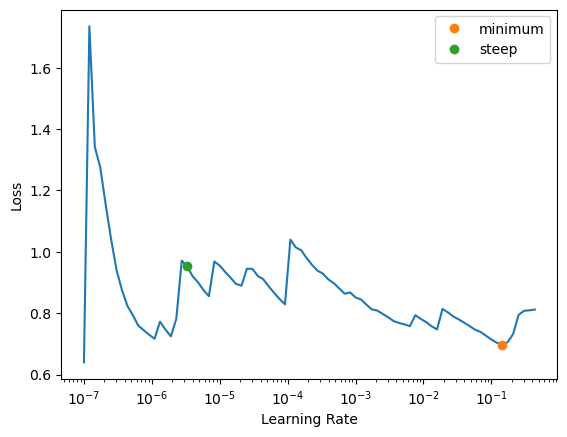

In [14]:
if trainNewModel:
    learn = tabular_learner(dls, metrics=[rmse, mae])

    # Learning rate finder
    lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

    # Debugging information
    print(f"Learning rate finder results: lr_min={lr_min}, lr_steep={lr_steep}")

    # Check if learning rates are valid
    if lr_min is None or lr_steep is None:
        raise ValueError("Learning rate finder did not return valid learning rates.")

    # Train
    print(f"Training for {epochs} epochs...")
    learn.fit_one_cycle(epochs, lr_max=lr_steep)
    print("Model training complete")

    learn.export(modelFolder / f'{modelName}.pkl')

## Testing and benchmarking

$JW.A: possibly delisted; no timezone found


Error fetching data for JW.A: No historical data available for JW.A around 2024-01-28.


$GYB: possibly delisted; no timezone found


Error fetching data for GYB: No historical data available for GYB around 2024-01-28.


$TKMR: possibly delisted; no timezone found
$CBAK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TKMR: No historical data available for TKMR around 2024-01-28.
Error fetching data for CBAK: No historical data available for CBAK around 2024-01-28.


$OVAS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for OVAS: No historical data available for OVAS around 2024-01-28.


$NTLS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NTLS: No historical data available for NTLS around 2024-01-28.


$XBKS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$ISH: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for XBKS: No historical data available for XBKS around 2024-01-28.
Error fetching data for ISH: No historical data available for ISH around 2024-01-28.


$CLR: possibly delisted; no timezone found
$BEE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CLR: No historical data available for CLR around 2024-01-28.
Error fetching data for BEE: No historical data available for BEE around 2024-01-28.


$AMAG: possibly delisted; no timezone found


Error fetching data for AMAG: No historical data available for AMAG around 2024-01-28.


$DDR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$CBEY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DDR: No historical data available for DDR around 2024-01-28.
Error fetching data for CBEY: No historical data available for CBEY around 2024-01-28.


$ZB-C: possibly delisted; no timezone found


Error fetching data for ZB-C: No historical data available for ZB-C around 2024-01-28.


$OFC: possibly delisted; no timezone found


Error fetching data for OFC: No historical data available for OFC around 2024-01-28.


$MNE: possibly delisted; no timezone found


Error fetching data for MNE: No historical data available for MNE around 2024-01-28.


$SPPI: possibly delisted; no timezone found
$MOCO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SPPI: No historical data available for SPPI around 2024-01-28.
Error fetching data for MOCO: No historical data available for MOCO around 2024-01-28.


$KDN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for KDN: No historical data available for KDN around 2024-01-28.


$DAEG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$RIT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DAEG: No historical data available for DAEG around 2024-01-28.
Error fetching data for RIT: No historical data available for RIT around 2024-01-28.


$KAMN: possibly delisted; no timezone found


Error fetching data for KAMN: No historical data available for KAMN around 2024-01-28.


$FFCO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FFCO: No historical data available for FFCO around 2024-01-28.


$PCMI: possibly delisted; no timezone found


Error fetching data for PCMI: No historical data available for PCMI around 2024-01-28.


$ACMP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ACMP: No historical data available for ACMP around 2024-01-28.


$PKH: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PKH: No historical data available for PKH around 2024-01-28.


$BML-G: possibly delisted; no timezone found
$UTIW: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BML-G: No historical data available for BML-G around 2024-01-28.
Error fetching data for UTIW: No historical data available for UTIW around 2024-01-28.


$INN-C: possibly delisted; no timezone found


Error fetching data for INN-C: No historical data available for INN-C around 2024-01-28.


$PSB-U: possibly delisted; no timezone found


Error fetching data for PSB-U: No historical data available for PSB-U around 2024-01-28.


$SBBX: possibly delisted; no timezone found
$MDCI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SBBX: No historical data available for SBBX around 2024-01-28.
Error fetching data for MDCI: No historical data available for MDCI around 2024-01-28.


$IXYS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for IXYS: No historical data available for IXYS around 2024-01-28.


$CWHN: possibly delisted; no timezone found


Error fetching data for CWHN: No historical data available for CWHN around 2024-01-28.


$GRO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28) (Yahoo error = "Data doesn't exist for startDate = 1703826000, endDate = 1706418000")


Error fetching data for GRO: No historical data available for GRO around 2024-01-28.


$AIG-WT: possibly delisted; no timezone found


Error fetching data for AIG-WT: No historical data available for AIG-WT around 2024-01-28.


$SEAS: possibly delisted; no timezone found
$NNP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$TSPT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SEAS: No historical data available for SEAS around 2024-01-28.
Error fetching data for NNP: No historical data available for NNP around 2024-01-28.
Error fetching data for TSPT: No historical data available for TSPT around 2024-01-28.


$NANO: possibly delisted; no timezone found


Error fetching data for NANO: No historical data available for NANO around 2024-01-28.


$CFI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CFI: No historical data available for CFI around 2024-01-28.


$NLY-C: possibly delisted; no timezone found


Error fetching data for NLY-C: No historical data available for NLY-C around 2024-01-28.


$RDA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$MEAS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for RDA: No historical data available for RDA around 2024-01-28.
Error fetching data for MEAS: No historical data available for MEAS around 2024-01-28.


$TCO: possibly delisted; no timezone found
$GA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$AMIC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TCO: No historical data available for TCO around 2024-01-28.
Error fetching data for GA: No historical data available for GA around 2024-01-28.
Error fetching data for AMIC: No historical data available for AMIC around 2024-01-28.


$NPI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$IPAS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$NKA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NPI: No historical data available for NPI around 2024-01-28.
Error fetching data for IPAS: No historical data available for IPAS around 2024-01-28.
Error fetching data for NKA: No historical data available for NKA around 2024-01-28.


$MRTX: possibly delisted; no timezone found


Error fetching data for MRTX: No historical data available for MRTX around 2024-01-28.


$RPRXW: possibly delisted; no timezone found


Error fetching data for RPRXW: No historical data available for RPRXW around 2024-01-28.


$NSR: possibly delisted; no timezone found


Error fetching data for NSR: No historical data available for NSR around 2024-01-28.


$MJN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MJN: No historical data available for MJN around 2024-01-28.


$WTFCW: possibly delisted; no timezone found


Error fetching data for WTFCW: No historical data available for WTFCW around 2024-01-28.


$SAN-C: possibly delisted; no timezone found


Error fetching data for SAN-C: No historical data available for SAN-C around 2024-01-28.


$CLCT: possibly delisted; no timezone found


Error fetching data for CLCT: No historical data available for CLCT around 2024-01-28.


$THGA: possibly delisted; no timezone found


Error fetching data for THGA: No historical data available for THGA around 2024-01-28.


$HPAC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$KRFT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HPAC: No historical data available for HPAC around 2024-01-28.
Error fetching data for KRFT: No historical data available for KRFT around 2024-01-28.


$RFMD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for RFMD: No historical data available for RFMD around 2024-01-28.


$USAT: possibly delisted; no timezone found


Error fetching data for USAT: No historical data available for USAT around 2024-01-28.


$ZNGA: possibly delisted; no timezone found
$SCMP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$AGU: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ZNGA: No historical data available for ZNGA around 2024-01-28.
Error fetching data for SCMP: No historical data available for SCMP around 2024-01-28.
Error fetching data for AGU: No historical data available for AGU around 2024-01-28.


$NTX: possibly delisted; no timezone found


Error fetching data for NTX: No historical data available for NTX around 2024-01-28.


$OFG-B: possibly delisted; no timezone found


Error fetching data for OFG-B: No historical data available for OFG-B around 2024-01-28.


$SGMS: possibly delisted; no timezone found


Error fetching data for SGMS: No historical data available for SGMS around 2024-01-28.


$PJL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$CBNJ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PJL: No historical data available for PJL around 2024-01-28.
Error fetching data for CBNJ: No historical data available for CBNJ around 2024-01-28.
Error fetching data for MP-D: Too Many Requests. Rate limited. Try after a while.
Error fetching data for EEQ: Too Many Requests. Rate limited. Try after a while.
Error fetching data for FSCI: Too Many Requests. Rate limited. Try after a while.
Error fetching data for CEM: Too Many Requests. Rate limited. Try after a while.
Error fetching data for GLT: Too Many Requests. Rate limited. Try after a while.
Error fetching data for BCS: Too Many Requests. Rate limited. Try after a while.
Error fetching data for UBNK: Too Many Requests. Rate limited. Try after a while.
Error fetching data for IMAX: Too Many Requests. Rate limited. Try after a while.
Error fetching data for ROLL: Too Many Requests. Rate limited. Try after a while.
Error fetching data for RGLD: Too Many Requests. Rate limited. Try after a while.
Error fetchi

$ISBC: possibly delisted; no timezone found


Error fetching data for ISBC: No historical data available for ISBC around 2024-01-28.


$ATRI: possibly delisted; no timezone found


Error fetching data for ATRI: No historical data available for ATRI around 2024-01-28.


$PSA-V: possibly delisted; no timezone found


Error fetching data for PSA-V: No historical data available for PSA-V around 2024-01-28.


$RJD: possibly delisted; no timezone found


Error fetching data for RJD: No historical data available for RJD around 2024-01-28.


$BRE-D: possibly delisted; no timezone found


Error fetching data for BRE-D: No historical data available for BRE-D around 2024-01-28.


$CIMT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CIMT: No historical data available for CIMT around 2024-01-28.


$CSG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CSG: No historical data available for CSG around 2024-01-28.


$EMCF: possibly delisted; no timezone found


Error fetching data for EMCF: No historical data available for EMCF around 2024-01-28.


$SVNT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SVNT: No historical data available for SVNT around 2024-01-28.


$ELOS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ELOS: No historical data available for ELOS around 2024-01-28.


$GDP-C: possibly delisted; no timezone found


Error fetching data for GDP-C: No historical data available for GDP-C around 2024-01-28.


$NHF: possibly delisted; no timezone found


Error fetching data for NHF: No historical data available for NHF around 2024-01-28.


$CERE: possibly delisted; no timezone found
$APSA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CERE: No historical data available for CERE around 2024-01-28.
Error fetching data for APSA: No historical data available for APSA around 2024-01-28.


$SWHC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$STJ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SWHC: No historical data available for SWHC around 2024-01-28.
Error fetching data for STJ: No historical data available for STJ around 2024-01-28.


$GMETP: possibly delisted; no timezone found
$MPG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GMETP: No historical data available for GMETP around 2024-01-28.
Error fetching data for MPG: No historical data available for MPG around 2024-01-28.


$DSKX: possibly delisted; no timezone found
$JPW: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DSKX: No historical data available for DSKX around 2024-01-28.
Error fetching data for JPW: No historical data available for JPW around 2024-01-28.


$HBOS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HBOS: No historical data available for HBOS around 2024-01-28.


$EFII: possibly delisted; no timezone found


Error fetching data for EFII: No historical data available for EFII around 2024-01-28.


$ZOLT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ZOLT: No historical data available for ZOLT around 2024-01-28.


$CCCL: possibly delisted; no timezone found


Error fetching data for CCCL: No historical data available for CCCL around 2024-01-28.


$COR-A: possibly delisted; no timezone found


Error fetching data for COR-A: No historical data available for COR-A around 2024-01-28.


$DPM: possibly delisted; no timezone found
$CADX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DPM: No historical data available for DPM around 2024-01-28.
Error fetching data for CADX: No historical data available for CADX around 2024-01-28.


$SSW-C: possibly delisted; no timezone found
$HGT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SSW-C: No historical data available for SSW-C around 2024-01-28.
Error fetching data for HGT: No historical data available for HGT around 2024-01-28.


$NNC-F: possibly delisted; no timezone found


Error fetching data for NNC-F: No historical data available for NNC-F around 2024-01-28.


$IGTE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for IGTE: No historical data available for IGTE around 2024-01-28.


$MDC: possibly delisted; no timezone found


Error fetching data for MDC: No historical data available for MDC around 2024-01-28.


$AKO.B: possibly delisted; no timezone found


Error fetching data for AKO.B: No historical data available for AKO.B around 2024-01-28.


$VLTC: possibly delisted; no timezone found
$STV: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for VLTC: No historical data available for VLTC around 2024-01-28.
Error fetching data for STV: No historical data available for STV around 2024-01-28.


$CVTI: possibly delisted; no timezone found
$ANR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CVTI: No historical data available for CVTI around 2024-01-28.
Error fetching data for ANR: No historical data available for ANR around 2024-01-28.


$MINI: possibly delisted; no timezone found


Error fetching data for MINI: No historical data available for MINI around 2024-01-28.


$TCP: possibly delisted; no timezone found


Error fetching data for TCP: No historical data available for TCP around 2024-01-28.


$SBNYW: possibly delisted; no timezone found


Error fetching data for SBNYW: No historical data available for SBNYW around 2024-01-28.


$EPR-F: possibly delisted; no timezone found


Error fetching data for EPR-F: No historical data available for EPR-F around 2024-01-28.


$NKG-D: possibly delisted; no timezone found


Error fetching data for NKG-D: No historical data available for NKG-D around 2024-01-28.


$ROIA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$BAGR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$ENI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ROIA: No historical data available for ROIA around 2024-01-28.
Error fetching data for BAGR: No historical data available for BAGR around 2024-01-28.
Error fetching data for ENI: No historical data available for ENI around 2024-01-28.


$MNRK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MNRK: No historical data available for MNRK around 2024-01-28.


$GTXI: possibly delisted; no timezone found
$TWC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$FSGI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GTXI: No historical data available for GTXI around 2024-01-28.
Error fetching data for TWC: No historical data available for TWC around 2024-01-28.
Error fetching data for FSGI: No historical data available for FSGI around 2024-01-28.


$RNET: possibly delisted; no timezone found


Error fetching data for RNET: No historical data available for RNET around 2024-01-28.


$NDP: possibly delisted; no price data found  (period=1d)


Error fetching data for NDP: single positional indexer is out-of-bounds


$NRF-A: possibly delisted; no timezone found


Error fetching data for NRF-A: No historical data available for NRF-A around 2024-01-28.


$MBLX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MBLX: No historical data available for MBLX around 2024-01-28.


$PTR: possibly delisted; no timezone found


Error fetching data for PTR: No historical data available for PTR around 2024-01-28.


$GSVC: possibly delisted; no timezone found
$EXAR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GSVC: No historical data available for GSVC around 2024-01-28.
Error fetching data for EXAR: No historical data available for EXAR around 2024-01-28.


$LNKD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$CQB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$WCRX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LNKD: No historical data available for LNKD around 2024-01-28.
Error fetching data for CQB: No historical data available for CQB around 2024-01-28.
Error fetching data for WCRX: No historical data available for WCRX around 2024-01-28.


$NUC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NUC: No historical data available for NUC around 2024-01-28.


$CHUY: possibly delisted; no timezone found


Error fetching data for CHUY: No historical data available for CHUY around 2024-01-28.


$LACO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LACO: No historical data available for LACO around 2024-01-28.


$FFNM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$KAP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FFNM: No historical data available for FFNM around 2024-01-28.
Error fetching data for KAP: No historical data available for KAP around 2024-01-28.


$ROC: possibly delisted; no timezone found


Error fetching data for ROC: No historical data available for ROC around 2024-01-28.


$GWPH: possibly delisted; no timezone found


Error fetching data for GWPH: No historical data available for GWPH around 2024-01-28.


$TEAR: possibly delisted; no timezone found


Error fetching data for TEAR: No historical data available for TEAR around 2024-01-28.


$CLACW: possibly delisted; no timezone found
$CACGU: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CLACW: No historical data available for CLACW around 2024-01-28.
Error fetching data for CACGU: No historical data available for CACGU around 2024-01-28.


$RNR-C: possibly delisted; no timezone found


Error fetching data for RNR-C: No historical data available for RNR-C around 2024-01-28.


$SONA: possibly delisted; no timezone found
$PULB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SONA: No historical data available for SONA around 2024-01-28.
Error fetching data for PULB: No historical data available for PULB around 2024-01-28.


$PRAN: possibly delisted; no timezone found


Error fetching data for PRAN: No historical data available for PRAN around 2024-01-28.


$KIM-I: possibly delisted; no timezone found


Error fetching data for KIM-I: No historical data available for KIM-I around 2024-01-28.


$KFH: possibly delisted; no timezone found


Error fetching data for KFH: No historical data available for KFH around 2024-01-28.


$IPXL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$BBCN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for IPXL: No historical data available for IPXL around 2024-01-28.
Error fetching data for BBCN: No historical data available for BBCN around 2024-01-28.


$GDP: possibly delisted; no timezone found
$CVB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GDP: No historical data available for GDP around 2024-01-28.
Error fetching data for CVB: No historical data available for CVB around 2024-01-28.


$BRE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$HJN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BRE: No historical data available for BRE around 2024-01-28.
Error fetching data for HJN: No historical data available for HJN around 2024-01-28.


$JCOM: possibly delisted; no timezone found
$DTSI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for JCOM: No historical data available for JCOM around 2024-01-28.
Error fetching data for DTSI: No historical data available for DTSI around 2024-01-28.


$NNA: possibly delisted; no timezone found
$SCOK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NNA: No historical data available for NNA around 2024-01-28.
Error fetching data for SCOK: No historical data available for SCOK around 2024-01-28.


$MSP: possibly delisted; no timezone found
$RUK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MSP: No historical data available for MSP around 2024-01-28.
Error fetching data for RUK: No historical data available for RUK around 2024-01-28.


$AAWW: possibly delisted; no timezone found


Error fetching data for AAWW: No historical data available for AAWW around 2024-01-28.


$NTC-D: possibly delisted; no timezone found


Error fetching data for NTC-D: No historical data available for NTC-D around 2024-01-28.


$SINA: possibly delisted; no timezone found


Error fetching data for SINA: No historical data available for SINA around 2024-01-28.


$LXP-C: possibly delisted; no timezone found


Error fetching data for LXP-C: No historical data available for LXP-C around 2024-01-28.


$OTEL: possibly delisted; no timezone found


Error fetching data for OTEL: No historical data available for OTEL around 2024-01-28.


$ZIONW: possibly delisted; no timezone found


Error fetching data for ZIONW: No historical data available for ZIONW around 2024-01-28.


$EAC: possibly delisted; no timezone found
$GGS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EAC: No historical data available for EAC around 2024-01-28.
Error fetching data for GGS: No historical data available for GGS around 2024-01-28.


$DEPO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DEPO: No historical data available for DEPO around 2024-01-28.


$NQC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NQC: No historical data available for NQC around 2024-01-28.


$MSZ: possibly delisted; no timezone found
$FRP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MSZ: No historical data available for MSZ around 2024-01-28.
Error fetching data for FRP: No historical data available for FRP around 2024-01-28.


$EAGLU: possibly delisted; no timezone found


Error fetching data for EAGLU: No historical data available for EAGLU around 2024-01-28.


$VIFL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for VIFL: No historical data available for VIFL around 2024-01-28.


$ULTR: possibly delisted; no price data found  (period=1d)


Error fetching data for ULTR: single positional indexer is out-of-bounds


$AWC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AWC: No historical data available for AWC around 2024-01-28.


$ATEA: possibly delisted; no timezone found


Error fetching data for ATEA: No historical data available for ATEA around 2024-01-28.


$VIAB: possibly delisted; no timezone found


Error fetching data for VIAB: No historical data available for VIAB around 2024-01-28.


$SPPRO: possibly delisted; no timezone found


Error fetching data for SPPRO: No historical data available for SPPRO around 2024-01-28.


$ISIG: possibly delisted; no timezone found


Error fetching data for ISIG: No historical data available for ISIG around 2024-01-28.


$RST: possibly delisted; no timezone found


Error fetching data for RST: No historical data available for RST around 2024-01-28.


$LCC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LCC: No historical data available for LCC around 2024-01-28.


$KHI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for KHI: No historical data available for KHI around 2024-01-28.


$TAST: possibly delisted; no timezone found
$TAI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TAST: No historical data available for TAST around 2024-01-28.
Error fetching data for TAI: No historical data available for TAI around 2024-01-28.


$IDT.P: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for IDT.P: No historical data available for IDT.P around 2024-01-28.


$ARN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$GMAN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$SQNM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ARN: No historical data available for ARN around 2024-01-28.
Error fetching data for GMAN: No historical data available for GMAN around 2024-01-28.
Error fetching data for SQNM: No historical data available for SQNM around 2024-01-28.


$PIY: possibly delisted; no timezone found


Error fetching data for PIY: No historical data available for PIY around 2024-01-28.


$MFRI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MFRI: No historical data available for MFRI around 2024-01-28.


$MZOR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MZOR: No historical data available for MZOR around 2024-01-28.
Error fetching data for TSN: Too Many Requests. Rate limited. Try after a while.
Error fetching data for KTOS: Too Many Requests. Rate limited. Try after a while.
Error fetching data for ATEC: Too Many Requests. Rate limited. Try after a while.
Error fetching data for BDGE: Too Many Requests. Rate limited. Try after a while.
Error fetching data for PAI: Too Many Requests. Rate limited. Try after a while.
Error fetching data for PL-E: Too Many Requests. Rate limited. Try after a while.
Error fetching data for CTQ: Too Many Requests. Rate limited. Try after a while.
Error fetching data for PDS: Too Many Requests. Rate limited. Try after a while.
Error fetching data for SIAL: Too Many Requests. Rate limited. Try after a while.
Error fetching data for ACM: Too Many Requests. Rate limited. Try after a while.
Error fetching data for HMST: Too Many Requests. Rate limited. Try after a while.
Error fetching d

$LSE-C: possibly delisted; no timezone found


Error fetching data for LSE-C: No historical data available for LSE-C around 2024-01-28.


$ADRA: possibly delisted; no timezone found


Error fetching data for ADRA: No historical data available for ADRA around 2024-01-28.


$HNP: possibly delisted; no timezone found
$WAG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HNP: No historical data available for HNP around 2024-01-28.
Error fetching data for WAG: No historical data available for WAG around 2024-01-28.


$GKM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GKM: No historical data available for GKM around 2024-01-28.


$CLAC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$CPGI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CLAC: No historical data available for CLAC around 2024-01-28.
Error fetching data for CPGI: No historical data available for CPGI around 2024-01-28.


$SUBK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SUBK: No historical data available for SUBK around 2024-01-28.


$NMK-C: possibly delisted; no timezone found


Error fetching data for NMK-C: No historical data available for NMK-C around 2024-01-28.


$DFT-A: possibly delisted; no timezone found
$MWV: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DFT-A: No historical data available for DFT-A around 2024-01-28.
Error fetching data for MWV: No historical data available for MWV around 2024-01-28.


$ACAT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ACAT: No historical data available for ACAT around 2024-01-28.


$LIQD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LIQD: No historical data available for LIQD around 2024-01-28.


$IRC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$VPFG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for IRC: No historical data available for IRC around 2024-01-28.
Error fetching data for VPFG: No historical data available for VPFG around 2024-01-28.


$GAM-B: possibly delisted; no timezone found


Error fetching data for GAM-B: No historical data available for GAM-B around 2024-01-28.


$BJZ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BJZ: No historical data available for BJZ around 2024-01-28.


$DDR-H: possibly delisted; no timezone found
$SPW: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DDR-H: No historical data available for DDR-H around 2024-01-28.
Error fetching data for SPW: No historical data available for SPW around 2024-01-28.


$UNS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for UNS: No historical data available for UNS around 2024-01-28.


$ASI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ASI: No historical data available for ASI around 2024-01-28.


$CTW: possibly delisted; no timezone found


Error fetching data for CTW: No historical data available for CTW around 2024-01-28.


$JZK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$ZIPR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for JZK: No historical data available for JZK around 2024-01-28.
Error fetching data for ZIPR: No historical data available for ZIPR around 2024-01-28.


$CWTR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$NCP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CWTR: No historical data available for CWTR around 2024-01-28.
Error fetching data for NCP: No historical data available for NCP around 2024-01-28.


$DW: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DW: No historical data available for DW around 2024-01-28.


$SOV-C: possibly delisted; no timezone found


Error fetching data for SOV-C: No historical data available for SOV-C around 2024-01-28.


$DRQ: possibly delisted; no timezone found


Error fetching data for DRQ: No historical data available for DRQ around 2024-01-28.


$ATMI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ATMI: No historical data available for ATMI around 2024-01-28.


$FLIR: possibly delisted; no timezone found


Error fetching data for FLIR: No historical data available for FLIR around 2024-01-28.


$BKK: possibly delisted; no timezone found


Error fetching data for BKK: No historical data available for BKK around 2024-01-28.


$CYTX: possibly delisted; no timezone found


Error fetching data for CYTX: No historical data available for CYTX around 2024-01-28.


$HWAY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28) (Yahoo error = "Data doesn't exist for startDate = 1703826000, endDate = 1706418000")


Error fetching data for HWAY: No historical data available for HWAY around 2024-01-28.


$CTB: possibly delisted; no timezone found


Error fetching data for CTB: No historical data available for CTB around 2024-01-28.


$DX-B: possibly delisted; no timezone found


Error fetching data for DX-B: No historical data available for DX-B around 2024-01-28.


$CLN-A: possibly delisted; no timezone found


Error fetching data for CLN-A: No historical data available for CLN-A around 2024-01-28.


$SQI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SQI: No historical data available for SQI around 2024-01-28.


$MCV: possibly delisted; no timezone found
$VELT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MCV: No historical data available for MCV around 2024-01-28.
Error fetching data for VELT: No historical data available for VELT around 2024-01-28.


$HGSH: possibly delisted; no timezone found


Error fetching data for HGSH: No historical data available for HGSH around 2024-01-28.


$IO: possibly delisted; no timezone found


Error fetching data for IO: No historical data available for IO around 2024-01-28.


$COT: possibly delisted; no timezone found


Error fetching data for COT: No historical data available for COT around 2024-01-28.


$OFC-L: possibly delisted; no timezone found


Error fetching data for OFC-L: No historical data available for OFC-L around 2024-01-28.


$AFAM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$DANG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AFAM: No historical data available for AFAM around 2024-01-28.
Error fetching data for DANG: No historical data available for DANG around 2024-01-28.


$CYN-C: possibly delisted; no timezone found


Error fetching data for CYN-C: No historical data available for CYN-C around 2024-01-28.


$MWRX: possibly delisted; no timezone found


Error fetching data for MWRX: No historical data available for MWRX around 2024-01-28.


$MOG.A: possibly delisted; no timezone found


Error fetching data for MOG.A: No historical data available for MOG.A around 2024-01-28.


$ERW: possibly delisted; no timezone found


Error fetching data for ERW: No historical data available for ERW around 2024-01-28.


$IDSA: possibly delisted; no timezone found
$RNDY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for IDSA: No historical data available for IDSA around 2024-01-28.
Error fetching data for RNDY: No historical data available for RNDY around 2024-01-28.


$DRE: possibly delisted; no timezone found


Error fetching data for DRE: No historical data available for DRE around 2024-01-28.


$CELGZ: possibly delisted; no timezone found


Error fetching data for CELGZ: No historical data available for CELGZ around 2024-01-28.


$POM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for POM: No historical data available for POM around 2024-01-28.


$POWR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for POWR: No historical data available for POWR around 2024-01-28.


$MXIM: possibly delisted; no timezone found


Error fetching data for MXIM: No historical data available for MXIM around 2024-01-28.


$CO: possibly delisted; no timezone found
$CNW: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CO: No historical data available for CO around 2024-01-28.
Error fetching data for CNW: No historical data available for CNW around 2024-01-28.


$SGYPW: possibly delisted; no timezone found
$FAC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SGYPW: No historical data available for SGYPW around 2024-01-28.
Error fetching data for FAC: No historical data available for FAC around 2024-01-28.


$TMNG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TMNG: No historical data available for TMNG around 2024-01-28.


$IRE-B: possibly delisted; no timezone found


Error fetching data for IRE-B: No historical data available for IRE-B around 2024-01-28.


$TBOW: possibly delisted; no timezone found
$PTGI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TBOW: No historical data available for TBOW around 2024-01-28.
Error fetching data for PTGI: No historical data available for PTGI around 2024-01-28.


$GSH: possibly delisted; no timezone found
$PACR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$CSRE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GSH: No historical data available for GSH around 2024-01-28.
Error fetching data for PACR: No historical data available for PACR around 2024-01-28.
Error fetching data for CSRE: No historical data available for CSRE around 2024-01-28.


$TDE: possibly delisted; no timezone found


Error fetching data for TDE: No historical data available for TDE around 2024-01-28.


$MBT: possibly delisted; no timezone found


Error fetching data for MBT: No historical data available for MBT around 2024-01-28.


$CMK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CMK: No historical data available for CMK around 2024-01-28.


$AFSI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AFSI: No historical data available for AFSI around 2024-01-28.


$STA-A: possibly delisted; no timezone found
$WFM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for STA-A: No historical data available for STA-A around 2024-01-28.
Error fetching data for WFM: No historical data available for WFM around 2024-01-28.


$DST: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DST: No historical data available for DST around 2024-01-28.


$RBS-S: possibly delisted; no timezone found


Error fetching data for RBS-S: No historical data available for RBS-S around 2024-01-28.


$BERK: possibly delisted; no timezone found
$THLD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BERK: No historical data available for BERK around 2024-01-28.
Error fetching data for THLD: No historical data available for THLD around 2024-01-28.


$CCIH: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CCIH: No historical data available for CCIH around 2024-01-28.


$GALTU: possibly delisted; no timezone found
$JMI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GALTU: No historical data available for GALTU around 2024-01-28.
Error fetching data for JMI: No historical data available for JMI around 2024-01-28.


$EXLP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EXLP: No historical data available for EXLP around 2024-01-28.


$CVCY: possibly delisted; no timezone found


Error fetching data for CVCY: No historical data available for CVCY around 2024-01-28.


$MGCD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MGCD: No historical data available for MGCD around 2024-01-28.


$AGO-E: possibly delisted; no timezone found
$BBRG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AGO-E: No historical data available for AGO-E around 2024-01-28.
Error fetching data for BBRG: No historical data available for BBRG around 2024-01-28.
Error fetching data for IPCI: Too Many Requests. Rate limited. Try after a while.
Error fetching data for SOCL: Too Many Requests. Rate limited. Try after a while.
Error fetching data for FHN-A: Too Many Requests. Rate limited. Try after a while.
Error fetching data for ATR: Too Many Requests. Rate limited. Try after a while.
Error fetching data for CIEN: Too Many Requests. Rate limited. Try after a while.
Error fetching data for EAB: Too Many Requests. Rate limited. Try after a while.
Error fetching data for ACUR: Too Many Requests. Rate limited. Try after a while.
Error fetching data for XRSC: Too Many Requests. Rate limited. Try after a while.
Error fetching data for MET: Too Many Requests. Rate limited. Try after a while.
Error fetching data for PNC: Too Many Requests. Rate limited. Try after a while.
Error f

$CRMBU: possibly delisted; no timezone found


Error fetching data for CRMBU: No historical data available for CRMBU around 2024-01-28.


$NSL: possibly delisted; no timezone found
$FCS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NSL: No historical data available for NSL around 2024-01-28.
Error fetching data for FCS: No historical data available for FCS around 2024-01-28.


$TTM: possibly delisted; no timezone found


Error fetching data for TTM: No historical data available for TTM around 2024-01-28.


$BOBE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$HNSN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BOBE: No historical data available for BOBE around 2024-01-28.
Error fetching data for HNSN: No historical data available for HNSN around 2024-01-28.


$HPT: possibly delisted; no timezone found


Error fetching data for HPT: No historical data available for HPT around 2024-01-28.


$DD-B: possibly delisted; no timezone found
$RALY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$NDZ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DD-B: No historical data available for DD-B around 2024-01-28.
Error fetching data for RALY: No historical data available for RALY around 2024-01-28.
Error fetching data for NDZ: No historical data available for NDZ around 2024-01-28.


$IBCPO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for IBCPO: No historical data available for IBCPO around 2024-01-28.


$TWX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TWX: No historical data available for TWX around 2024-01-28.


$BF.A: possibly delisted; no timezone found


Error fetching data for BF.A: No historical data available for BF.A around 2024-01-28.


$CSU: possibly delisted; no timezone found
$LVNTB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CSU: No historical data available for CSU around 2024-01-28.
Error fetching data for LVNTB: No historical data available for LVNTB around 2024-01-28.


$ATVI: possibly delisted; no timezone found


Error fetching data for ATVI: No historical data available for ATVI around 2024-01-28.


$ESD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$KFN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ESD: No historical data available for ESD around 2024-01-28.
Error fetching data for KFN: No historical data available for KFN around 2024-01-28.


$RE: possibly delisted; no timezone found


Error fetching data for RE: No historical data available for RE around 2024-01-28.


$TTHI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TTHI: No historical data available for TTHI around 2024-01-28.


$PGI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PGI: No historical data available for PGI around 2024-01-28.


$BIOL: possibly delisted; no timezone found


Error fetching data for BIOL: No historical data available for BIOL around 2024-01-28.


$ELN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ELN: No historical data available for ELN around 2024-01-28.


$KRC-H: possibly delisted; no timezone found


Error fetching data for KRC-H: No historical data available for KRC-H around 2024-01-28.


$GS-J: possibly delisted; no timezone found
$OKS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GS-J: No historical data available for GS-J around 2024-01-28.
Error fetching data for OKS: No historical data available for OKS around 2024-01-28.


$FNP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$REDF: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for FNP: No historical data available for FNP around 2024-01-28.
Error fetching data for REDF: No historical data available for REDF around 2024-01-28.


$MNR-B: possibly delisted; no timezone found


Error fetching data for MNR-B: No historical data available for MNR-B around 2024-01-28.


$MER-E: possibly delisted; no timezone found


Error fetching data for MER-E: No historical data available for MER-E around 2024-01-28.


$CSS: possibly delisted; no timezone found


Error fetching data for CSS: No historical data available for CSS around 2024-01-28.


$SCTY: possibly delisted; no timezone found
$KWK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SCTY: No historical data available for SCTY around 2024-01-28.
Error fetching data for KWK: No historical data available for KWK around 2024-01-28.


$ROVI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ROVI: No historical data available for ROVI around 2024-01-28.


$NBL: possibly delisted; no timezone found


Error fetching data for NBL: No historical data available for NBL around 2024-01-28.


$SXCP: possibly delisted; no timezone found


Error fetching data for SXCP: No historical data available for SXCP around 2024-01-28.


$HVB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HVB: No historical data available for HVB around 2024-01-28.


$JACQU: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for JACQU: No historical data available for JACQU around 2024-01-28.


$UEPS: possibly delisted; no timezone found
$PBCP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$AMTG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for UEPS: No historical data available for UEPS around 2024-01-28.
Error fetching data for PBCP: No historical data available for PBCP around 2024-01-28.
Error fetching data for AMTG: No historical data available for AMTG around 2024-01-28.


$UBP-F: possibly delisted; no timezone found


Error fetching data for UBP-F: No historical data available for UBP-F around 2024-01-28.


$HHC: possibly delisted; no timezone found
$CLACU: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HHC: No historical data available for HHC around 2024-01-28.
Error fetching data for CLACU: No historical data available for CLACU around 2024-01-28.


$REG-G: possibly delisted; no timezone found


Error fetching data for REG-G: No historical data available for REG-G around 2024-01-28.


$PSA-Q: possibly delisted; no timezone found


Error fetching data for PSA-Q: No historical data available for PSA-Q around 2024-01-28.


$GS-A: possibly delisted; no timezone found
$LXK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GS-A: No historical data available for GS-A around 2024-01-28.
Error fetching data for LXK: No historical data available for LXK around 2024-01-28.


$KYN-E: possibly delisted; no timezone found


Error fetching data for KYN-E: No historical data available for KYN-E around 2024-01-28.


$DTZ: possibly delisted; no timezone found


Error fetching data for DTZ: No historical data available for DTZ around 2024-01-28.


$HMSY: possibly delisted; no timezone found


Error fetching data for HMSY: No historical data available for HMSY around 2024-01-28.


$TBAC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TBAC: No historical data available for TBAC around 2024-01-28.


$TROVU: possibly delisted; no timezone found


Error fetching data for TROVU: No historical data available for TROVU around 2024-01-28.


$AMNB: possibly delisted; no timezone found


Error fetching data for AMNB: No historical data available for AMNB around 2024-01-28.


$GRA: possibly delisted; no timezone found


Error fetching data for GRA: No historical data available for GRA around 2024-01-28.


$CYS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CYS: No historical data available for CYS around 2024-01-28.


$PMCS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PMCS: No historical data available for PMCS around 2024-01-28.


$AGO-PF: possibly delisted; no timezone found


Error fetching data for AGO-PF: No historical data available for AGO-PF around 2024-01-28.


$ABR-PA: possibly delisted; no timezone found


Error fetching data for ABR-PA: No historical data available for ABR-PA around 2024-01-28.


$SPRT: possibly delisted; no timezone found


Error fetching data for SPRT: No historical data available for SPRT around 2024-01-28.


$LNCO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$STAN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LNCO: No historical data available for LNCO around 2024-01-28.
Error fetching data for STAN: No historical data available for STAN around 2024-01-28.


$ATU: possibly delisted; no timezone found


Error fetching data for ATU: No historical data available for ATU around 2024-01-28.


$NTG: possibly delisted; no price data found  (period=1d)


Error fetching data for NTG: single positional indexer is out-of-bounds


$CPSL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28) (Yahoo error = "Data doesn't exist for startDate = 1703826000, endDate = 1706418000")


Error fetching data for CPSL: No historical data available for CPSL around 2024-01-28.


$GNI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$RCAP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GNI: No historical data available for GNI around 2024-01-28.
Error fetching data for RCAP: No historical data available for RCAP around 2024-01-28.


$JTP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$DOVR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for JTP: No historical data available for JTP around 2024-01-28.
Error fetching data for DOVR: No historical data available for DOVR around 2024-01-28.


$ELNK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ELNK: No historical data available for ELNK around 2024-01-28.


$RGDO: possibly delisted; no timezone found


Error fetching data for RGDO: No historical data available for RGDO around 2024-01-28.


$GJV: possibly delisted; no timezone found


Error fetching data for GJV: No historical data available for GJV around 2024-01-28.


$USATP: possibly delisted; no timezone found


Error fetching data for USATP: No historical data available for USATP around 2024-01-28.


$IRR: possibly delisted; no timezone found


Error fetching data for IRR: No historical data available for IRR around 2024-01-28.


$UAM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for UAM: No historical data available for UAM around 2024-01-28.


$FISV: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28) (Yahoo error = "No data found, symbol may be delisted")


Error fetching data for FISV: No historical data available for FISV around 2024-01-28.


$SCHN: possibly delisted; no timezone found


Error fetching data for SCHN: No historical data available for SCHN around 2024-01-28.


$PRSC: possibly delisted; no timezone found


Error fetching data for PRSC: No historical data available for PRSC around 2024-01-28.


$SB-B: possibly delisted; no timezone found


Error fetching data for SB-B: No historical data available for SB-B around 2024-01-28.


$MTGE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MTGE: No historical data available for MTGE around 2024-01-28.


$BQH: possibly delisted; no timezone found


Error fetching data for BQH: No historical data available for BQH around 2024-01-28.


$NCO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NCO: No historical data available for NCO around 2024-01-28.


$SANWZ: possibly delisted; no timezone found


Error fetching data for SANWZ: No historical data available for SANWZ around 2024-01-28.


$GS-B: possibly delisted; no timezone found


Error fetching data for GS-B: No historical data available for GS-B around 2024-01-28.


$CVD: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$RUE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CVD: No historical data available for CVD around 2024-01-28.
Error fetching data for RUE: No historical data available for RUE around 2024-01-28.


$MNI: possibly delisted; no timezone found


Error fetching data for MNI: No historical data available for MNI around 2024-01-28.


$BRK.A: possibly delisted; no timezone found
$NTSC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for BRK.A: No historical data available for BRK.A around 2024-01-28.
Error fetching data for NTSC: No historical data available for NTSC around 2024-01-28.


$JFC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for JFC: No historical data available for JFC around 2024-01-28.


$SNHN: possibly delisted; no timezone found


Error fetching data for SNHN: No historical data available for SNHN around 2024-01-28.


$SXL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SXL: No historical data available for SXL around 2024-01-28.


$TOT: possibly delisted; no timezone found
$NFEC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$BOI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TOT: No historical data available for TOT around 2024-01-28.
Error fetching data for NFEC: No historical data available for NFEC around 2024-01-28.
Error fetching data for BOI: No historical data available for BOI around 2024-01-28.


$MTU: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MTU: No historical data available for MTU around 2024-01-28.


$CNBC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$RIMG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CNBC: No historical data available for CNBC around 2024-01-28.
Error fetching data for RIMG: No historical data available for RIMG around 2024-01-28.


$VTNR: possibly delisted; no timezone found
$SKH: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for VTNR: No historical data available for VTNR around 2024-01-28.
Error fetching data for SKH: No historical data available for SKH around 2024-01-28.


$NXR: possibly delisted; no timezone found


Error fetching data for NXR: No historical data available for NXR around 2024-01-28.


$CFC-B: possibly delisted; no timezone found


Error fetching data for CFC-B: No historical data available for CFC-B around 2024-01-28.


$SGY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$NRGY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SGY: No historical data available for SGY around 2024-01-28.
Error fetching data for NRGY: No historical data available for NRGY around 2024-01-28.


$SLW: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SLW: No historical data available for SLW around 2024-01-28.


$CHK: possibly delisted; no timezone found


Error fetching data for CHK: No historical data available for CHK around 2024-01-28.


$SAAS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SAAS: No historical data available for SAAS around 2024-01-28.


$GFED: possibly delisted; no timezone found


Error fetching data for GFED: No historical data available for GFED around 2024-01-28.
Error fetching data for KUTV: Too Many Requests. Rate limited. Try after a while.
Error fetching data for SANW: Too Many Requests. Rate limited. Try after a while.
Error fetching data for AMP-A: Too Many Requests. Rate limited. Try after a while.
Error fetching data for DCO: Too Many Requests. Rate limited. Try after a while.
Error fetching data for WAB: Too Many Requests. Rate limited. Try after a while.
Error fetching data for NOM-C: Too Many Requests. Rate limited. Try after a while.
Error fetching data for ALL-B: Too Many Requests. Rate limited. Try after a while.
Error fetching data for GEO: Too Many Requests. Rate limited. Try after a while.
Error fetching data for PSF: Too Many Requests. Rate limited. Try after a while.
Error fetching data for AWF: Too Many Requests. Rate limited. Try after a while.
Error fetching data for PATH: Too Many Requests. Rate limited. Try after a while.
Error fetchin

$PNF: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PNF: No historical data available for PNF around 2024-01-28.


$BPL: possibly delisted; no timezone found


Error fetching data for BPL: No historical data available for BPL around 2024-01-28.


$EIHI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EIHI: No historical data available for EIHI around 2024-01-28.


$OFG-A: possibly delisted; no timezone found
$SGL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for OFG-A: No historical data available for OFG-A around 2024-01-28.
Error fetching data for SGL: No historical data available for SGL around 2024-01-28.


$XXIA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$CAB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for XXIA: No historical data available for XXIA around 2024-01-28.
Error fetching data for CAB: No historical data available for CAB around 2024-01-28.


$SPLK: possibly delisted; no timezone found
$OVRL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SPLK: No historical data available for SPLK around 2024-01-28.
Error fetching data for OVRL: No historical data available for OVRL around 2024-01-28.


$GARS: possibly delisted; no timezone found


Error fetching data for GARS: No historical data available for GARS around 2024-01-28.


$RDS.A: possibly delisted; no timezone found


Error fetching data for RDS.A: No historical data available for RDS.A around 2024-01-28.


$PIKE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PIKE: No historical data available for PIKE around 2024-01-28.


$WHFBL: possibly delisted; no timezone found


Error fetching data for WHFBL: No historical data available for WHFBL around 2024-01-28.


$FRX: possibly delisted; no timezone found


Error fetching data for FRX: No historical data available for FRX around 2024-01-28.


$EXAM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EXAM: No historical data available for EXAM around 2024-01-28.


$USB-M: possibly delisted; no timezone found


Error fetching data for USB-M: No historical data available for USB-M around 2024-01-28.


$PSE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PSE: No historical data available for PSE around 2024-01-28.


$SINO: possibly delisted; no timezone found
$ANCI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SINO: No historical data available for SINO around 2024-01-28.
Error fetching data for ANCI: No historical data available for ANCI around 2024-01-28.


$IRDMZ: possibly delisted; no timezone found


Error fetching data for IRDMZ: No historical data available for IRDMZ around 2024-01-28.


$C-R: possibly delisted; no timezone found
$TAYCP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for C-R: No historical data available for C-R around 2024-01-28.
Error fetching data for TAYCP: No historical data available for TAYCP around 2024-01-28.


$RLH-A: possibly delisted; no timezone found


Error fetching data for RLH-A: No historical data available for RLH-A around 2024-01-28.


$ESBK: possibly delisted; no timezone found


Error fetching data for ESBK: No historical data available for ESBK around 2024-01-28.


$CLVS: possibly delisted; no timezone found


Error fetching data for CLVS: No historical data available for CLVS around 2024-01-28.


$PYG: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$LTXC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PYG: No historical data available for PYG around 2024-01-28.
Error fetching data for LTXC: No historical data available for LTXC around 2024-01-28.


$DMND: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$KEYW: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DMND: No historical data available for DMND around 2024-01-28.
Error fetching data for KEYW: No historical data available for KEYW around 2024-01-28.


$OMN: possibly delisted; no timezone found
$FLTX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$ENH: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for OMN: No historical data available for OMN around 2024-01-28.
Error fetching data for FLTX: No historical data available for FLTX around 2024-01-28.
Error fetching data for ENH: No historical data available for ENH around 2024-01-28.


$TSYS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TSYS: No historical data available for TSYS around 2024-01-28.


$TRIT: possibly delisted; no timezone found


Error fetching data for TRIT: No historical data available for TRIT around 2024-01-28.


$USB-N: possibly delisted; no timezone found


Error fetching data for USB-N: No historical data available for USB-N around 2024-01-28.


$HTBX: possibly delisted; no timezone found


Error fetching data for HTBX: No historical data available for HTBX around 2024-01-28.


$TRLA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TRLA: No historical data available for TRLA around 2024-01-28.


$AKRX: possibly delisted; no timezone found
$CHC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AKRX: No historical data available for AKRX around 2024-01-28.
Error fetching data for CHC: No historical data available for CHC around 2024-01-28.


$VSCP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for VSCP: No historical data available for VSCP around 2024-01-28.


$COG: possibly delisted; no timezone found
$TAYC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for COG: No historical data available for COG around 2024-01-28.
Error fetching data for TAYC: No historical data available for TAYC around 2024-01-28.


$CCH: possibly delisted; no timezone found


Error fetching data for CCH: No historical data available for CCH around 2024-01-28.


$EAE: possibly delisted; no timezone found


Error fetching data for EAE: No historical data available for EAE around 2024-01-28.


$MFT: possibly delisted; no timezone found
$BAMM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MFT: No historical data available for MFT around 2024-01-28.
Error fetching data for BAMM: No historical data available for BAMM around 2024-01-28.


$SAQ: possibly delisted; no timezone found


Error fetching data for SAQ: No historical data available for SAQ around 2024-01-28.


$MHFI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MHFI: No historical data available for MHFI around 2024-01-28.


$NEE-G: possibly delisted; no timezone found


Error fetching data for NEE-G: No historical data available for NEE-G around 2024-01-28.


$ASCA: possibly delisted; no timezone found
$LAYN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ASCA: No historical data available for ASCA around 2024-01-28.
Error fetching data for LAYN: No historical data available for LAYN around 2024-01-28.


$LVNTA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LVNTA: No historical data available for LVNTA around 2024-01-28.


$YGE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$PGH: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for YGE: No historical data available for YGE around 2024-01-28.
Error fetching data for PGH: No historical data available for PGH around 2024-01-28.


$CVLY: possibly delisted; no timezone found


Error fetching data for CVLY: No historical data available for CVLY around 2024-01-28.


$COA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for COA: No historical data available for COA around 2024-01-28.


$CERN: possibly delisted; no timezone found


Error fetching data for CERN: No historical data available for CERN around 2024-01-28.


$TELK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for TELK: No historical data available for TELK around 2024-01-28.


$NZH-B: possibly delisted; no timezone found


Error fetching data for NZH-B: No historical data available for NZH-B around 2024-01-28.


$NPP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for NPP: No historical data available for NPP around 2024-01-28.


$MWR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MWR: No historical data available for MWR around 2024-01-28.


$NEE-J: possibly delisted; no timezone found


Error fetching data for NEE-J: No historical data available for NEE-J around 2024-01-28.


$HNT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HNT: No historical data available for HNT around 2024-01-28.


$NLNK: possibly delisted; no timezone found


Error fetching data for NLNK: No historical data available for NLNK around 2024-01-28.


$HOLI: possibly delisted; no timezone found


Error fetching data for HOLI: No historical data available for HOLI around 2024-01-28.


$SHI: possibly delisted; no timezone found


Error fetching data for SHI: No historical data available for SHI around 2024-01-28.


$DDR-J: possibly delisted; no timezone found


Error fetching data for DDR-J: No historical data available for DDR-J around 2024-01-28.


$NID: possibly delisted; no timezone found
$GPRC: possibly delisted; no price data found  (period=1d)


Error fetching data for NID: No historical data available for NID around 2024-01-28.
Error fetching data for GPRC: single positional indexer is out-of-bounds


$RMGN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for RMGN: No historical data available for RMGN around 2024-01-28.


$HILL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HILL: No historical data available for HILL around 2024-01-28.


$PVR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PVR: No historical data available for PVR around 2024-01-28.


$MPAC: possibly delisted; no timezone found


Error fetching data for MPAC: No historical data available for MPAC around 2024-01-28.


$AET: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AET: No historical data available for AET around 2024-01-28.


$NMY-D: possibly delisted; no timezone found


Error fetching data for NMY-D: No historical data available for NMY-D around 2024-01-28.


$JOEZ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for JOEZ: No historical data available for JOEZ around 2024-01-28.


$RPRXZ: possibly delisted; no timezone found
$MJI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for RPRXZ: No historical data available for RPRXZ around 2024-01-28.
Error fetching data for MJI: No historical data available for MJI around 2024-01-28.


$CRZO: possibly delisted; no timezone found


Error fetching data for CRZO: No historical data available for CRZO around 2024-01-28.


$PRIS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PRIS: No historical data available for PRIS around 2024-01-28.


$MER-K: possibly delisted; no timezone found


Error fetching data for MER-K: No historical data available for MER-K around 2024-01-28.


$MTB-C: possibly delisted; no timezone found


Error fetching data for MTB-C: No historical data available for MTB-C around 2024-01-28.


$GIGA: possibly delisted; no timezone found


Error fetching data for GIGA: No historical data available for GIGA around 2024-01-28.


$NYCB: possibly delisted; no timezone found


Error fetching data for NYCB: No historical data available for NYCB around 2024-01-28.


$CTL: possibly delisted; no timezone found
$ORB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CTL: No historical data available for CTL around 2024-01-28.
Error fetching data for ORB: No historical data available for ORB around 2024-01-28.


$PMTC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$REXX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PMTC: No historical data available for PMTC around 2024-01-28.
Error fetching data for REXX: No historical data available for REXX around 2024-01-28.


$ATHX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ATHX: No historical data available for ATHX around 2024-01-28.


$MUS: possibly delisted; no timezone found
$UCBA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MUS: No historical data available for MUS around 2024-01-28.
Error fetching data for UCBA: No historical data available for UCBA around 2024-01-28.


$SCU: possibly delisted; no timezone found


Error fetching data for SCU: No historical data available for SCU around 2024-01-28.


$AFW: possibly delisted; no timezone found


Error fetching data for AFW: No historical data available for AFW around 2024-01-28.


$FRBK: possibly delisted; no timezone found


Error fetching data for FRBK: No historical data available for FRBK around 2024-01-28.


$AV: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AV: No historical data available for AV around 2024-01-28.


$PHH: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28) (Yahoo error = "Data doesn't exist for startDate = 1703826000, endDate = 1706418000")


Error fetching data for PHH: No historical data available for PHH around 2024-01-28.


$TMK: possibly delisted; no timezone found


Error fetching data for TMK: No historical data available for TMK around 2024-01-28.


$UCBI: possibly delisted; no timezone found


Error fetching data for UCBI: No historical data available for UCBI around 2024-01-28.


$AGN: possibly delisted; no timezone found


Error fetching data for AGN: No historical data available for AGN around 2024-01-28.


$CCIX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28) (Yahoo error = "Data doesn't exist for startDate = 1703826000, endDate = 1706418000")


Error fetching data for CCIX: No historical data available for CCIX around 2024-01-28.


$MTOR: possibly delisted; no timezone found


Error fetching data for MTOR: No historical data available for MTOR around 2024-01-28.


$BFS-C: possibly delisted; no timezone found


Error fetching data for BFS-C: No historical data available for BFS-C around 2024-01-28.


$SREV: possibly delisted; no timezone found


Error fetching data for SREV: No historical data available for SREV around 2024-01-28.


$END: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$DSCI: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for END: No historical data available for END around 2024-01-28.
Error fetching data for DSCI: No historical data available for DSCI around 2024-01-28.


$SAEX: possibly delisted; no timezone found


Error fetching data for SAEX: No historical data available for SAEX around 2024-01-28.


$EXL-B: possibly delisted; no timezone found
$WBCO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EXL-B: No historical data available for EXL-B around 2024-01-28.
Error fetching data for WBCO: No historical data available for WBCO around 2024-01-28.


$PFSW: possibly delisted; no timezone found


Error fetching data for PFSW: No historical data available for PFSW around 2024-01-28.


$PFG-B: possibly delisted; no timezone found


Error fetching data for PFG-B: No historical data available for PFG-B around 2024-01-28.


$TCBIP: possibly delisted; no timezone found


Error fetching data for TCBIP: No historical data available for TCBIP around 2024-01-28.


$HOLL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HOLL: No historical data available for HOLL around 2024-01-28.


$SUTR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SUTR: No historical data available for SUTR around 2024-01-28.


$EOC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for EOC: No historical data available for EOC around 2024-01-28.


$STL: possibly delisted; no timezone found


Error fetching data for STL: No historical data available for STL around 2024-01-28.


$HTS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HTS: No historical data available for HTS around 2024-01-28.


$SAPE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$CCE: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SAPE: No historical data available for SAPE around 2024-01-28.
Error fetching data for CCE: No historical data available for CCE around 2024-01-28.


$MFO: possibly delisted; no timezone found


Error fetching data for MFO: No historical data available for MFO around 2024-01-28.


$GPT-A: possibly delisted; no timezone found


Error fetching data for GPT-A: No historical data available for GPT-A around 2024-01-28.


$TNP-B: possibly delisted; no timezone found


Error fetching data for TNP-B: No historical data available for TNP-B around 2024-01-28.


$ECA: possibly delisted; no timezone found


Error fetching data for ECA: No historical data available for ECA around 2024-01-28.


$LAS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for LAS: No historical data available for LAS around 2024-01-28.


$NTC-F: possibly delisted; no timezone found


Error fetching data for NTC-F: No historical data available for NTC-F around 2024-01-28.


$AIF: possibly delisted; no timezone found


Error fetching data for AIF: No historical data available for AIF around 2024-01-28.


$TLI: possibly delisted; no timezone found


Error fetching data for TLI: No historical data available for TLI around 2024-01-28.


$HSKA: possibly delisted; no timezone found
$EMQ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for HSKA: No historical data available for HSKA around 2024-01-28.
Error fetching data for EMQ: No historical data available for EMQ around 2024-01-28.


$VIMC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for VIMC: No historical data available for VIMC around 2024-01-28.


$CETV: possibly delisted; no timezone found


Error fetching data for CETV: No historical data available for CETV around 2024-01-28.


$ARU: possibly delisted; no timezone found


Error fetching data for ARU: No historical data available for ARU around 2024-01-28.


$GXP: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$KORS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for GXP: No historical data available for GXP around 2024-01-28.
Error fetching data for KORS: No historical data available for KORS around 2024-01-28.


$GCAP: possibly delisted; no timezone found


Error fetching data for GCAP: No historical data available for GCAP around 2024-01-28.


$PICO: possibly delisted; no timezone found
$IRF: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PICO: No historical data available for PICO around 2024-01-28.
Error fetching data for IRF: No historical data available for IRF around 2024-01-28.


$COF.W: possibly delisted; no timezone found


Error fetching data for COF.W: No historical data available for COF.W around 2024-01-28.


$UIS-A: possibly delisted; no timezone found


Error fetching data for UIS-A: No historical data available for UIS-A around 2024-01-28.


$TCCA: possibly delisted; no timezone found


Error fetching data for TCCA: No historical data available for TCCA around 2024-01-28.


$DNR: possibly delisted; no timezone found


Error fetching data for DNR: No historical data available for DNR around 2024-01-28.


$BCS-D: possibly delisted; no timezone found


Error fetching data for BCS-D: No historical data available for BCS-D around 2024-01-28.


$SLT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SLT: No historical data available for SLT around 2024-01-28.


$CUB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28) (Yahoo error = "Data doesn't exist for startDate = 1703826000, endDate = 1706418000")
$DYAX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$CBMX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CUB: No historical data available for CUB around 2024-01-28.
Error fetching data for DYAX: No historical data available for DYAX around 2024-01-28.
Error fetching data for CBMX: No historical data available for CBMX around 2024-01-28.


$CECE: possibly delisted; no timezone found


Error fetching data for CECE: No historical data available for CECE around 2024-01-28.


$CTIB: possibly delisted; no timezone found


Error fetching data for CTIB: No historical data available for CTIB around 2024-01-28.


$PSB-V: possibly delisted; no timezone found
$HJR: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PSB-V: No historical data available for PSB-V around 2024-01-28.
Error fetching data for HJR: No historical data available for HJR around 2024-01-28.


$AFT: possibly delisted; no timezone found


Error fetching data for AFT: No historical data available for AFT around 2024-01-28.


$QLIK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for QLIK: No historical data available for QLIK around 2024-01-28.


$ZIOP: possibly delisted; no timezone found


Error fetching data for ZIOP: No historical data available for ZIOP around 2024-01-28.


$FRC-A: possibly delisted; no timezone found


Error fetching data for FRC-A: No historical data available for FRC-A around 2024-01-28.


$FCE.B: possibly delisted; no timezone found


Error fetching data for FCE.B: No historical data available for FCE.B around 2024-01-28.


$TI.A: possibly delisted; no timezone found


Error fetching data for TI.A: No historical data available for TI.A around 2024-01-28.


$PSA-O: possibly delisted; no timezone found


Error fetching data for PSA-O: No historical data available for PSA-O around 2024-01-28.


$WEBK: possibly delisted; no timezone found


Error fetching data for WEBK: No historical data available for WEBK around 2024-01-28.


$KIM-K: possibly delisted; no timezone found


Error fetching data for KIM-K: No historical data available for KIM-K around 2024-01-28.


$CPSI: possibly delisted; no timezone found
$ESRX: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for CPSI: No historical data available for CPSI around 2024-01-28.
Error fetching data for ESRX: No historical data available for ESRX around 2024-01-28.


$OBAF: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for OBAF: No historical data available for OBAF around 2024-01-28.


$BSE: possibly delisted; no timezone found


Error fetching data for BSE: No historical data available for BSE around 2024-01-28.


$OAKS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$DRAM: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$ZLC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for OAKS: No historical data available for OAKS around 2024-01-28.
Error fetching data for DRAM: No historical data available for DRAM around 2024-01-28.
Error fetching data for ZLC: No historical data available for ZLC around 2024-01-28.


$SPG-J: possibly delisted; no timezone found


Error fetching data for SPG-J: No historical data available for SPG-J around 2024-01-28.


$CSOD: possibly delisted; no timezone found


Error fetching data for CSOD: No historical data available for CSOD around 2024-01-28.


$RNR-E: possibly delisted; no timezone found


Error fetching data for RNR-E: No historical data available for RNR-E around 2024-01-28.


$SNTA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$CWZ: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for SNTA: No historical data available for SNTA around 2024-01-28.
Error fetching data for CWZ: No historical data available for CWZ around 2024-01-28.


$MTB-A: possibly delisted; no timezone found


Error fetching data for MTB-A: No historical data available for MTB-A around 2024-01-28.


$TNP: possibly delisted; no timezone found


Error fetching data for TNP: No historical data available for TNP around 2024-01-28.


$INF: possibly delisted; no timezone found
$HDY: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for INF: No historical data available for INF around 2024-01-28.
Error fetching data for HDY: No historical data available for HDY around 2024-01-28.


$TMK-B: possibly delisted; no timezone found


Error fetching data for TMK-B: No historical data available for TMK-B around 2024-01-28.


$AEH: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for AEH: No historical data available for AEH around 2024-01-28.


$HVT.A: possibly delisted; no timezone found


Error fetching data for HVT.A: No historical data available for HVT.A around 2024-01-28.


$PKI: possibly delisted; no timezone found
$PNK: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for PKI: No historical data available for PKI around 2024-01-28.
Error fetching data for PNK: No historical data available for PNK around 2024-01-28.


$KIPO: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$TECUA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for KIPO: No historical data available for KIPO around 2024-01-28.
Error fetching data for TECUA: No historical data available for TECUA around 2024-01-28.


$ANCB: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for ANCB: No historical data available for ANCB around 2024-01-28.


$IL: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$FES: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for IL: No historical data available for IL around 2024-01-28.
Error fetching data for FES: No historical data available for FES around 2024-01-28.


$HL-B: possibly delisted; no timezone found


Error fetching data for HL-B: No historical data available for HL-B around 2024-01-28.


$MER-D: possibly delisted; no timezone found


Error fetching data for MER-D: No historical data available for MER-D around 2024-01-28.


$LSE-A: possibly delisted; no timezone found


Error fetching data for LSE-A: No historical data available for LSE-A around 2024-01-28.


$CAJ: possibly delisted; no timezone found


Error fetching data for CAJ: No historical data available for CAJ around 2024-01-28.


$VLYWW: possibly delisted; no timezone found


Error fetching data for VLYWW: No historical data available for VLYWW around 2024-01-28.


$UBSH: possibly delisted; no timezone found


Error fetching data for UBSH: No historical data available for UBSH around 2024-01-28.


$SUNS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28) (Yahoo error = "Data doesn't exist for startDate = 1703826000, endDate = 1706418000")


Error fetching data for SUNS: No historical data available for SUNS around 2024-01-28.


$HCCI: possibly delisted; no timezone found


Error fetching data for HCCI: No historical data available for HCCI around 2024-01-28.


$QQQC: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for QQQC: No historical data available for QQQC around 2024-01-28.


$DGIT: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for DGIT: No historical data available for DGIT around 2024-01-28.


$NGX-C: possibly delisted; no timezone found


Error fetching data for NGX-C: No historical data available for NGX-C around 2024-01-28.


$UBPS: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for UBPS: No historical data available for UBPS around 2024-01-28.


$MTSN: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)
$AHT-PA: possibly delisted; no price data found  (1d 2023-12-29 -> 2024-01-28)


Error fetching data for MTSN: No historical data available for MTSN around 2024-01-28.
Error fetching data for AHT-PA: No historical data available for AHT-PA around 2024-01-28.
Error fetching data for GBL: Too Many Requests. Rate limited. Try after a while.
Error fetching data for MWO: Too Many Requests. Rate limited. Try after a while.
Error fetching data for DAKT: Too Many Requests. Rate limited. Try after a while.
Error fetching data for GM.B: Too Many Requests. Rate limited. Try after a while.
Error fetching data for FWLT: Too Many Requests. Rate limited. Try after a while.
Error fetching data for ECOM: Too Many Requests. Rate limited. Try after a while.
Error fetching data for HPQ: Too Many Requests. Rate limited. Try after a while.
Error fetching data for OLED: Too Many Requests. Rate limited. Try after a while.
Error fetching data for BZH: Too Many Requests. Rate limited. Try after a while.
Error fetching data for ADM: Too Many Requests. Rate limited. Try after a while.
Error f

Logged evaluation results to /Users/victor/Documents/GitHub/VS-Code/Side-Projects/TrainedModels/stockScreener/modelEvaluations.csv


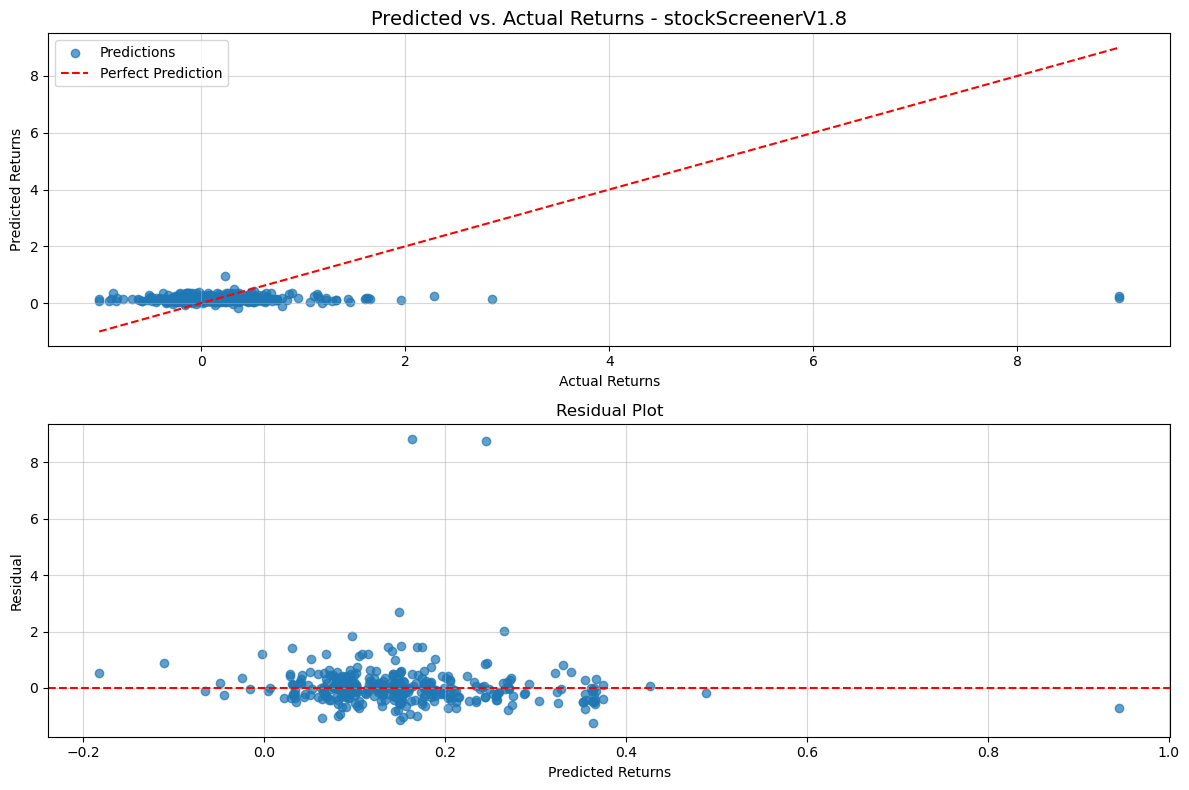

Collected 394 valid test tickers (target: 500)

Evaluation Results:
MAE: 0.363
RMSE: 0.780
R²: -0.007


In [17]:
def logEvaluation(model_name, mae, rmse, r2, model_folder, test_tickers):
    """Log evaluation metrics to CSV file"""
    log_file = model_folder / "modelEvaluations.csv"
    
    new_entry_df = pd.DataFrame([{
        "Model Name": model_name,
        "Timestamp": datetime.now().strftime('%Y-%m-%d %H:%M'),
        "MAE": f'{mae:.3f}',
        "RMSE": f'{rmse:.3f}',
        "R2": f'{r2:.3f}',
        "Epochs": epochs,
        "Training Size": trainingSize,
        "Test Size": len(test_tickers),
        "Cat Names": catNames,
        "Cont Names": contNames,
    }])
    
    try:
        log_df = pd.read_csv(log_file)
        log_df = pd.concat([log_df, new_entry_df], ignore_index=True)
    except FileNotFoundError:
        log_df = new_entry_df
        
    log_df.to_csv(log_file, index=False)
    print(f"Logged evaluation results to {log_file}")

def plotResults(results_df, model_name, model_folder):
    """Create and save visualization plots using all data points."""
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.scatter(results_df['Actual'], results_df['Predicted'], alpha=0.7, label='Predictions')
    min_val = min(results_df['Actual'].min(), results_df['Predicted'].min())
    max_val = max(results_df['Actual'].max(), results_df['Predicted'].max())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')
    plt.title(f'Predicted vs. Actual Returns - {model_name}', fontsize=14)
    plt.xlabel('Actual Returns')
    plt.ylabel('Predicted Returns')
    plt.legend()
    plt.grid(alpha=0.5)
    
    plt.subplot(2, 1, 2)
    plt.scatter(results_df['Predicted'], results_df['Residual'], alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residual Plot')
    plt.xlabel('Predicted Returns')
    plt.ylabel('Residual')
    plt.grid(alpha=0.5)
    
    plt.tight_layout()
    plt.show()

if trainNewModel:
    nonTrainingTickers = list(set(tickers) - set(trainingTickers))
    validTestData = []
    attempted_tickers = set()
    attempts = 0

    if testSize * 4 <= len(tickers):  
        max_attempts = testSize * 4 # Prevent infinite loops
    else:
        max_attempts = len(tickers)

    # Keep trying until we reach testSize or exhaust attempts
    while len(validTestData) < testSize and attempts < max_attempts:
        # Get a new ticker we haven't tried yet
        remaining_tickers = [t for t in nonTrainingTickers if t not in attempted_tickers]
        if not remaining_tickers:  # If all tried, reset attempted list
            attempted_tickers = set()
            remaining_tickers = nonTrainingTickers
            
        ticker = np.random.choice(remaining_tickers)
        attempted_tickers.add(ticker)
        attempts += 1

        # Fetch and validate data
        data = getTickerDataFrom1YrAgo(ticker)
        if not data.empty and not data[['EV/EBIT', 'ROIC']].isna().any().any():
            validTestData.append(data)

    if not validTestData:
        raise ValueError("No valid test data collected after multiple attempts")
        
    # Trim to exact testSize if we collected more
    validTestData = validTestData[:testSize]  
    combinedTestData = pd.concat(validTestData, ignore_index=True)

    # Clean data
    test_data_clean = combinedTestData.dropna(subset=['EV/EBIT', 'ROIC', 'Future Year Change'])
    
    if test_data_clean.empty:
        raise ValueError("No valid test data after cleaning NaN values")

    # Create test dataloader
    test_dl = learn.dls.test_dl(test_data_clean)
    preds, targs = learn.get_preds(dl=test_dl)
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'Predicted': preds.numpy().flatten(),
        'Actual': targs.numpy().flatten()
    })
    results_df['Residual'] = results_df['Actual'] - results_df['Predicted']

    # Calculate metrics
    mae = np.mean(np.abs(results_df['Residual']))
    rmse = np.sqrt(np.mean(results_df['Residual']**2))
    r2 = 1 - (np.sum(results_df['Residual']**2) / np.sum((results_df['Actual'] - results_df['Actual'].mean())**2))

    # Log and plot
    logEvaluation(modelName, mae, rmse, r2, modelFolder, test_data_clean['Ticker'].unique())
    plotResults(results_df, modelName, modelFolder)

    # Show collection stats
    print(f"Collected {len(validTestData)} valid test tickers (target: {testSize})")
    if attempts >= max_attempts:
        print(f"Warning: Reached max attempts ({max_attempts}). Some invalid tickers may remain.")  
    print(f"\nEvaluation Results:")
    print(f"MAE: {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²: {r2:.3f}")

## Predictions

In [18]:
print('Model files in modelFolder:')
for file in modelFolder.glob('*.pkl'):
    print(file.name)

Model files in modelFolder:
stockScreenerV1.5.pkl
stockScreenerV1.4.pkl
stockScreenerV1.6.pkl
stockScreenerV1.7.pkl
stockScreenerV1.3.pkl
stockScreenerV1.2.pkl
stockScreenerV1.0.pkl
stockScreenerV1.1.pkl
stockScreenerV1.8.pkl


In [23]:
evaluations = pd.read_csv(modelFolder / 'modelEvaluations.csv')
bestModel = evaluations.sort_values('MAE', ascending=True).iloc[0]
bestModel.head()

Model Name    stockScreenerV1.7
Timestamp      2025-01-27 08:45
MAE                       0.328
RMSE                      0.739
R2                        0.077
Name: 7, dtype: object

### Load model

In [24]:
if os.name == 'nt':
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
else:
    pathlib.WindowsPath = pathlib.PosixPath

importedModel = Path(f"{bestModel['Model Name']}.pkl") # Change this if you want to try other models
learn = load_learner(modelFolder / importedModel)

In [27]:
predictionTarget = '95%'

In [28]:
if predictionTarget != 'None':
    if predictionTarget == 'ALL':
        predictionTickers = tickers
    elif predictionTarget.endswith('%'):
        percentage = float(predictionTarget.strip('%')) / 100
        num_tickers = int(len(tickers) * percentage)
        predictionTickers = np.random.choice(tickers, size=num_tickers, replace=False).tolist()
    else:
        predictionTickers = [predictionTarget]

    # Fetch data for prediction tickers
    dfPrediction = pd.concat([getTickerData(ticker) for ticker in predictionTickers], ignore_index=True)

    # Ensure dfPrediction is a DataFrame
    if isinstance(dfPrediction, dict):
        dfPrediction = pd.DataFrame([dfPrediction])

    # Drop rows with NaN values in 'EV/EBIT' or 'ROIC'
    dfPrediction = dfPrediction.dropna(subset=['EV/EBIT', 'ROIC'])

    # Create test dataloader
    dl = learn.dls.test_dl(dfPrediction)
    dfPrediction.head()

    # Make predictions
    prediction = learn.get_preds(dl=dl)
    adr_df = pd.read_csv(testFolder / 'tickers.csv')
    company_dict = dict(zip(adr_df['Ticker'], adr_df['Company']))

    if predictionTarget == 'ALL' or predictionTarget.endswith('%'):
        sorted_predictions = sorted(zip(predictionTickers, prediction[0]), key=lambda x: x[1], reverse=True)
        print(f"Got predictions for {len(sorted_predictions)} tickers, expected: {len(predictionTickers)}")
        print(f"Prediction for best performing tickers:")
        for symbol, pred in sorted_predictions:
            company_name = company_dict.get(symbol, 'Unknown')
            print(f"{symbol} ({company_name}): {pred[0].item() * 100:.2f}%")
    else:
        company_name = company_dict.get(predictionTarget, 'Unknown')
        print(f"Prediction for {predictionTarget} ({company_name}):")
        print(f"{prediction[0][0][0].item() * 100:.2f}%")
    print("Free money?!")

$CASM: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
$DDF: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/DDF?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=DDF&crumb=Tr46MLUnkGG
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/DDF?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=DDF&crumb=Tr46MLUnkGG
$GDP: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
$NW-C: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: No

Got predictions for 1568 tickers, expected: 5491
Prediction for best performing tickers:
OCR-B (Omnicare Cap TR II): 2367.97%
DELL (Dell Inc.): 1857.67%
ICAD (Icad Inc.): 190.62%
BSI (Alon Holdings - Blue Square Israel Ltd): 108.25%
LMCA (Liberty Media Corp. Series A): 67.67%
HBHC (Hancock Holding Company): 64.31%
CACH (Cache): 56.73%
STRS (Stratus Properties): 52.33%
HMNY (Helios & Matheson North America Inc.): 51.02%
GSJK (Compressco Partners L.P.): 50.31%
TSCO (Tractor Supply Company): 46.86%
PSA-P (Public Storage): 46.21%
GRR (Asia Tigers Fund): 43.39%
RPRXW (Repros Therapeutics Inc.): 43.11%
MCRL (Micrel Inc.): 42.75%
HJV (Ms S.A.C. Saturns Ge Series 2002-14): 41.84%
GLF (Gulfmark Offshore): 41.29%
USMD (Usmd Holdings Inc.): 40.39%
QLGC (Qlogic Corp.): 40.36%
FFHL (Fuwei Films Co.): 39.31%
OXLC (Oxford Lane Capital): 38.58%
EGOV (Nic Inc.): 37.69%
NVX-A (Nuveen California Dividend Adva): 36.06%
JCE (Nuveen Core Equity Alpha Fund): 35.91%
MAV (Pioneer Muni High Income Advantage Tru